

*   **Team Name:**Team 414
*   **Team members:**Shantanu Ravindra Kale,Sai Manikanta Bandi,Meng Huang,Varshni Ravishankar
*   **Executive Summary of the Project:**

**Project Title**: Enhancing Supermarket Operations with Text Analytics

**Objective**:
The goal of this project is to leverage advanced data analytics to enhance the operations of supermarkets by understanding customer behaviors, preferences, and temporal visitation patterns.

**Key Findings**:
- Topic modeling on customer reviews has identified core themes such as food preferences, customer service quality, store cleanliness, and specific product mentions.
- Sentiment analysis suggests that events and seasonal offerings (e.g., Christmas) have a significant impact on customer sentiment.
- Temporal analysis indicates potential seasonal and weekly trends in customer check-ins, which correlate with fluctuations in review sentiments.



*   **Data Sources:**

*   yelp_academic_dataset_business
*   yelp_academic_dataset_review
*   yelp_academic_dataset_checkin

**Filtering Criteria**:
The project harnesses data from multiple sources, including customer check-in timestamps, business information, and customer reviews. The dataset encompasses various supermarkets across regions, with a focus on Arizona (AZ).

**Links/External Sources**:
https://www.yelp.com/dataset










In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --upgrade pandas==1.5.1
!pip install -q pyLDAvis==3.4.0

In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import pandas as pd
import numpy as np
import spacy
import os
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn
import pyLDAvis.lda_model
import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install -q vaderSentiment

In [6]:
import pandas as pd

# File paths for each dataset

#checkin_path = pd.read_csv('/content/drive/MyDrive/Yelp_Data/yelp_academic_dataset_checkin.csv')
individual=pd.read_csv('/content/drive/MyDrive/individual_timestamps.csv')
merged_df = pd.read_csv('/content/drive/MyDrive/merged_reviews.csv') # Combination of business and review dataset

#merged_df.head()
#review_path.head()
#checkin_path.head()


In [7]:
# Sort the dataframe by the 'useful' column in descending order
sorted_data = merged_df.sort_values(by='useful', ascending=False)
# Display the first few rows of the sorted dataframe
print(sorted_data.head())


                 business_id                 name              address  \
3058  ndVkAn-YN-Yb-C1lMwjkeg   Whole Foods Market     7133 N Oracle Rd   
3248  J495vfS5vmGP_H3zuNa4LQ  Walmart Supercenter  18680 S Nogales Hwy   
3209  J495vfS5vmGP_H3zuNa4LQ  Walmart Supercenter  18680 S Nogales Hwy   
3240  J495vfS5vmGP_H3zuNa4LQ  Walmart Supercenter  18680 S Nogales Hwy   
3236  J495vfS5vmGP_H3zuNa4LQ  Walmart Supercenter  18680 S Nogales Hwy   

              city state  postal_code   latitude   longitude  stars_x  \
3058        Tucson    AZ        85704  32.336556 -110.978349      3.5   
3248  Green Valley    AZ        85614  31.912165 -110.982585      2.0   
3209  Green Valley    AZ        85614  31.912165 -110.982585      2.0   
3240  Green Valley    AZ        85614  31.912165 -110.982585      2.0   
3236  Green Valley    AZ        85614  31.912165 -110.982585      2.0   

      review_count  ...  stars_y cool                 user_id useful  \
3058           102  ...      5.0  112  I-4KV

In [8]:
# Extract only the date portion (YYYY-MM-DD) from the 'date' column
sorted_dates_only = sorted_data['date'].str[:10]
# Display the first few dates in the YYYY-MM-DD format
sorted_dates_only.head()

3058    2021-02-28
3248    2020-11-19
3209    2020-11-26
3240    2020-11-19
3236    2021-04-13
Name: date, dtype: object

In [9]:
pip install textblob

In [10]:
from textblob import TextBlob

# Function to label sentiment as 0 (Negative or Neutral) and 1 (Positive)
def label_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    return 1 if polarity > 0 else 0
sorted_data['sentiment'] = sorted_data['text'].apply(label_sentiment)
# Display the first few rows to check the 'sentiment' column
print(sorted_data[['text', 'sentiment']].head())
sorted_data.count()

                                                   text  sentiment
3058  As we make our ways together these days it's a...          1
3248  I bought a helmet here, and the FBI showed up ...          0
3209  It is perfectly believable the manager lied to...          1
3240  The manager of this Walmart got someone arrest...          0
3236  Don't wear a hat and listen to music. Manager ...          0


business_id      3252
name             3252
address          3252
city             3252
state            3252
postal_code      3252
latitude         3252
longitude        3252
stars_x          3252
review_count     3252
is_open          3252
attributes       3252
categories       3252
hours            3186
funny            3252
stars_y          3252
cool             3252
user_id          3252
useful           3252
text             3252
date             3252
review_id        3252
tokens           3252
num_tokens       3252
review_length    3252
sentiment        3252
dtype: int64

In [44]:
# Filter the DataFrame to include only rows where the sentiment is 1
positive_sentiment_data = sorted_data[sorted_data['sentiment'] == 1]
# Display the first few rows of the sorted positive sentiment data
#positive_sentiment_data.head()
positive_sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2458 entries, 3058 to 2335
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   business_id    2458 non-null   object 
 1   name           2458 non-null   object 
 2   address        2458 non-null   object 
 3   city           2458 non-null   object 
 4   state          2458 non-null   object 
 5   postal_code    2458 non-null   int64  
 6   latitude       2458 non-null   float64
 7   longitude      2458 non-null   float64
 8   stars_x        2458 non-null   float64
 9   review_count   2458 non-null   int64  
 10  is_open        2458 non-null   int64  
 11  attributes     2458 non-null   object 
 12  categories     2458 non-null   object 
 13  hours          2412 non-null   object 
 14  funny          2458 non-null   int64  
 15  stars_y        2458 non-null   float64
 16  cool           2458 non-null   int64  
 17  user_id        2458 non-null   object 
 18  usefu

In [12]:
negative_sentiment_data = sorted_data[sorted_data['sentiment'] == 0]
negative_sentiment_data.head()
#negative_sentiment_data.to_csv("/content/drive/MyDrive/negative_sentiment_data.csv", index=False)
#negative_sentiment_data.count()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,cool,user_id,useful,text,date,review_id,tokens,num_tokens,review_length,sentiment
3248,J495vfS5vmGP_H3zuNa4LQ,Walmart Supercenter,18680 S Nogales Hwy,Green Valley,AZ,85614,31.912165,-110.982585,2.0,54,...,3,ewd_FNzt4YbsCnL5JdNj8A,28,"I bought a helmet here, and the FBI showed up ...",2020-11-19 21:56:49,mIjdZE8LKtkrubS7hm8eYA,"['I', 'bought', 'a', 'helmet', 'here', ',', 'a...",21,18,0
3240,J495vfS5vmGP_H3zuNa4LQ,Walmart Supercenter,18680 S Nogales Hwy,Green Valley,AZ,85614,31.912165,-110.982585,2.0,54,...,0,vGNRtm_d6JlRV4JLA2KP7g,28,The manager of this Walmart got someone arrest...,2020-11-19 15:13:43,2AUh_QWJWRAJs2ncCdNErw,"['The', 'manager', 'of', 'this', 'Walmart', 'g...",23,21,0
3236,J495vfS5vmGP_H3zuNa4LQ,Walmart Supercenter,18680 S Nogales Hwy,Green Valley,AZ,85614,31.912165,-110.982585,2.0,54,...,2,knj_SM_vh5F4pgdgwjXvZg,23,Don't wear a hat and listen to music. Manager ...,2021-04-13 20:49:27,gp7cO8jooDr1Ew6hEVC-3w,"['Do', ""n't"", 'wear', 'a', 'hat', 'and', 'list...",22,19,0
3232,J495vfS5vmGP_H3zuNa4LQ,Walmart Supercenter,18680 S Nogales Hwy,Green Valley,AZ,85614,31.912165,-110.982585,2.0,54,...,2,b1pp1dYNdwAKX3NL24sUyw,19,"By far the worst Walmart ever, a manager that ...",2021-09-29 11:46:02,o1bwrZGNT4ie6WXgZQGXMQ,"['By', 'far', 'the', 'worst', 'Walmart', 'ever...",87,79,0
359,-y5vYOsyL4bSFxeOtQtYbg,AJ's Fine Foods,2805 E Skyline Dr,Tucson,AZ,85718,32.324425,-110.931614,4.0,258,...,1,2h4mhlztAf-EpFPHRld-TA,16,Just visited Aj's this morning to visit the de...,2020-03-24 22:33:24,9_bvOiapyG1E1YqNPl58DA,"['Just', 'visited', 'Aj', ""'s"", 'this', 'morni...",331,276,0


In [13]:
import pandas as pd

# Assuming 'sorted_data' contains the positive sentiment data

# Filter the positive sentiment data for entries with star ratings >= 3
positive_star_rating = sorted_data[sorted_data['stars_x'] >= 3]

# Sort the positive sentiment data by 'name' and 'stars_x' in descending order of stars_x
positive_star_rating_sorted = positive_star_rating.sort_values(by=['name', 'stars_x'], ascending=[True, False])

# Display the first few rows of the sorted positive sentiment data
print(positive_star_rating_sorted.head())

# Filter the positive_star_rating_sorted DataFrame for entries with sentiment equal to 1
positive_sentiment_1 = positive_star_rating_sorted[positive_star_rating_sorted['sentiment'] == 1]

# Find the name with the most reviews where sentiment score is equal to 1
name_most_reviews = positive_sentiment_1['name'].value_counts().idxmax()

# Display the name with the most reviews and sentiment score equal to 1
print("Name with the most reviews and sentiment score equal to 1:", name_most_reviews)

# Count the number of reviews for each business name where sentiment score is equal to 1
reviews_count_per_name = positive_sentiment_1['name'].value_counts()

# Display the count of reviews for each business name where sentiment score is equal to 1
print("Count of reviews for each business name with sentiment score equal to 1:")
print(reviews_count_per_name)

# Count the number of reviews for each business ID
reviews_count_per_business_id = positive_star_rating_sorted['business_id'].value_counts()

# Map business IDs to names
business_id_to_name = positive_star_rating_sorted.set_index('business_id')['name']

# Map business IDs to names and count the number of reviews for each business name
reviews_count_per_business_name = reviews_count_per_business_id.rename(index=business_id_to_name)

# Display the count of reviews for each business name
print("Count of reviews for each business name:")
print(reviews_count_per_business_name)


                business_id             name            address    city state  \
359  -y5vYOsyL4bSFxeOtQtYbg  AJ's Fine Foods  2805 E Skyline Dr  Tucson    AZ   
151  -y5vYOsyL4bSFxeOtQtYbg  AJ's Fine Foods  2805 E Skyline Dr  Tucson    AZ   
329  -y5vYOsyL4bSFxeOtQtYbg  AJ's Fine Foods  2805 E Skyline Dr  Tucson    AZ   
288  -y5vYOsyL4bSFxeOtQtYbg  AJ's Fine Foods  2805 E Skyline Dr  Tucson    AZ   
343  -y5vYOsyL4bSFxeOtQtYbg  AJ's Fine Foods  2805 E Skyline Dr  Tucson    AZ   

     postal_code   latitude   longitude  stars_x  review_count  ...  cool  \
359        85718  32.324425 -110.931614      4.0           258  ...     1   
151        85718  32.324425 -110.931614      4.0           258  ...     1   
329        85718  32.324425 -110.931614      4.0           258  ...     7   
288        85718  32.324425 -110.931614      4.0           258  ...     2   
343        85718  32.324425 -110.931614      4.0           258  ...     0   

                    user_id useful  \
359  2h4mhlz

In [14]:
positive_star_rating = sorted_data[sorted_data['stars_x'] >= 3]
# Display the first few rows of the sorted positive sentiment data
#positive_star_rating.head()
positive_star_rating.count()

business_id      2135
name             2135
address          2135
city             2135
state            2135
postal_code      2135
latitude         2135
longitude        2135
stars_x          2135
review_count     2135
is_open          2135
attributes       2135
categories       2135
hours            2117
funny            2135
stars_y          2135
cool             2135
user_id          2135
useful           2135
text             2135
date             2135
review_id        2135
tokens           2135
num_tokens       2135
review_length    2135
sentiment        2135
dtype: int64

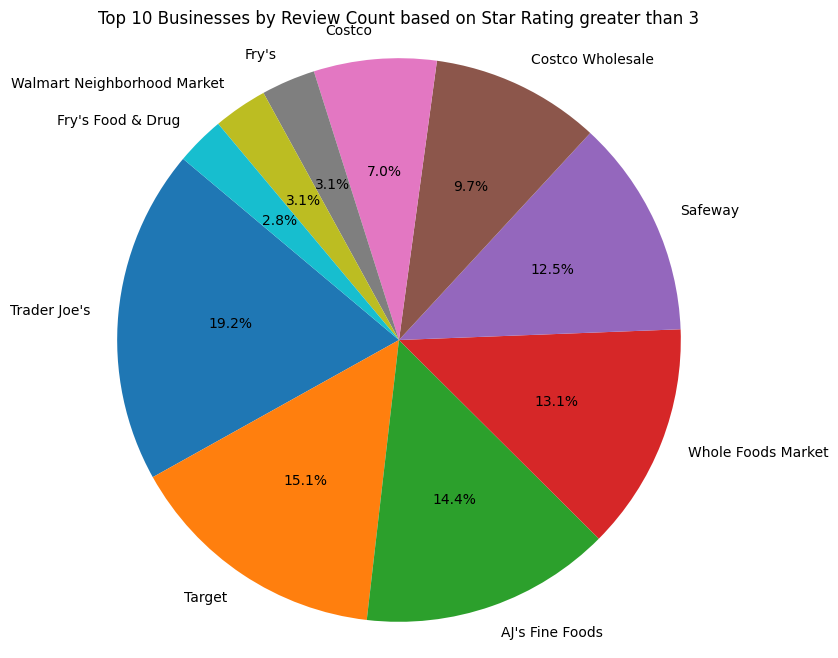

In [15]:
import matplotlib.pyplot as plt

# Get the top 10 business names with the highest review counts
top_business_names = reviews_count_per_name.head(10)

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_business_names, labels=top_business_names.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Businesses by Review Count based on Star Rating greater than 3')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [16]:
import pandas as pd

# Filter the positive sentiment data for entries with star ratings < 3
negative_star_rating = sorted_data[sorted_data['stars_x'] < 3]

# Filter the negative_star_rating DataFrame for entries with sentiment equal to 0
negative_sentiment_0 = negative_star_rating[negative_star_rating['sentiment'] == 0]

# Sort the negative sentiment data by 'name' and 'stars_x' in descending order of stars_x
negative_sentiment_0_sorted = negative_sentiment_0.sort_values(by=['name', 'stars_x'], ascending=[True, False])

# Display the first few rows of the sorted negative sentiment data
print(negative_sentiment_0_sorted.head())

# Find the name with the most reviews where sentiment score is equal to 0
name_highest_sentiment_0 = negative_sentiment_0_sorted['name'].value_counts().idxmax()

# Display the name with the most reviews and sentiment score equal to 0
print("Name with the highest sentiment score of 0 and star rating less than 3:", name_highest_sentiment_0)

# Count the number of reviews for each business name where sentiment score is equal to 0
reviews_count_per_name_sentiment_0 = negative_sentiment_0_sorted['name'].value_counts()

# Display the count of reviews for each business name where sentiment score is equal to 0
print("Count of reviews for each business name with sentiment score equal to 0 and star rating less than 3:")
print(reviews_count_per_name_sentiment_0)

# Remaining operations for positive sentiment (similar to the previous code snippet)
# Count the number of reviews for each business ID
reviews_count_per_business_id = negative_sentiment_0_sorted['business_id'].value_counts()

# Map business IDs to names
business_id_to_name = negative_sentiment_0_sorted.set_index('business_id')['name']

# Map business IDs to names and count the number of reviews for each business name
reviews_count_per_business_name = reviews_count_per_business_id.rename(index=business_id_to_name)

# Display the count of reviews for each business name
print("Count of reviews for each business name:")
print(reviews_count_per_business_name)


                 business_id               name               address    city  \
1208  H5wy6ck0OEKWH2nshX-Hjg  Fry's Food & Drug  7870 N Silverbell Rd  Tucson   
1204  H5wy6ck0OEKWH2nshX-Hjg  Fry's Food & Drug  7870 N Silverbell Rd  Tucson   
1197  H5wy6ck0OEKWH2nshX-Hjg  Fry's Food & Drug  7870 N Silverbell Rd  Tucson   
1194  H5wy6ck0OEKWH2nshX-Hjg  Fry's Food & Drug  7870 N Silverbell Rd  Tucson   
1196  H5wy6ck0OEKWH2nshX-Hjg  Fry's Food & Drug  7870 N Silverbell Rd  Tucson   

     state  postal_code   latitude   longitude  stars_x  review_count  ...  \
1208    AZ        85743  32.350385 -111.099879      2.5            21  ...   
1204    AZ        85743  32.350385 -111.099879      2.5            21  ...   
1197    AZ        85743  32.350385 -111.099879      2.5            21  ...   
1194    AZ        85743  32.350385 -111.099879      2.5            21  ...   
1196    AZ        85743  32.350385 -111.099879      2.5            21  ...   

      cool                 user_id useful  \

In [17]:
negative_star_rating = sorted_data[sorted_data['stars_x'] < 3]
# Display the first few rows of the sorted positive sentiment data
#positive_star_rating.head()
negative_star_rating.count()

business_id      1117
name             1117
address          1117
city             1117
state            1117
postal_code      1117
latitude         1117
longitude        1117
stars_x          1117
review_count     1117
is_open          1117
attributes       1117
categories       1117
hours            1069
funny            1117
stars_y          1117
cool             1117
user_id          1117
useful           1117
text             1117
date             1117
review_id        1117
tokens           1117
num_tokens       1117
review_length    1117
sentiment        1117
dtype: int64

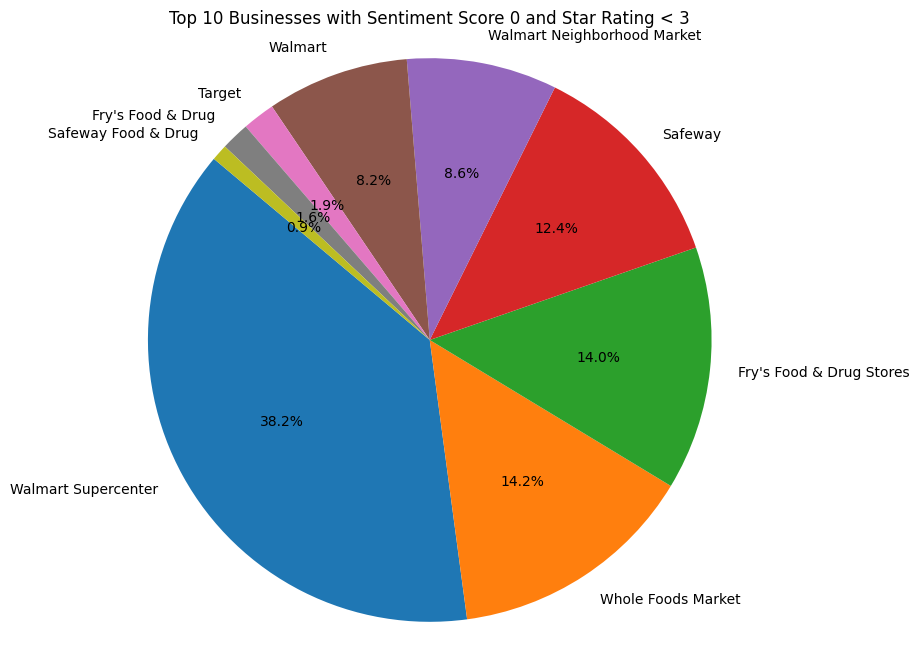

In [18]:
import matplotlib.pyplot as plt

# Get the top 10 business names with the highest review counts where sentiment score is equal to 0 and star rating is less than 3
top_negative_names = reviews_count_per_name_sentiment_0.head(10)

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_negative_names, labels=top_negative_names.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Businesses with Sentiment Score 0 and Star Rating < 3')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [76]:
# Re-import necessary libraries and reload the data due to code execution state reset
import pandas as pd

# Load the positive and negative sentiment data
positive_df = pd.read_csv('/content/drive/MyDrive/positive_sentiment_data.csv')
negative_df = pd.read_csv('/content/drive/MyDrive/negative_sentiment_data.csv')

# Label the data
positive_df['sentiment'] = 'positive'
negative_df['sentiment'] = 'negative'

# Merge the two datasets
merged_sentiment_df = pd.concat([positive_df, negative_df], ignore_index=True)

# Display the structure of the merged dataframe
merged_sentiment_df.head(), merged_sentiment_df['sentiment'].value_counts()


(              business_id                 name               address  \
 0  ndVkAn-YN-Yb-C1lMwjkeg   Whole Foods Market      7133 N Oracle Rd   
 1  J495vfS5vmGP_H3zuNa4LQ  Walmart Supercenter   18680 S Nogales Hwy   
 2  7MgH7P0IYBI7Vq34JZm2Zw   Whole Foods Market  3360 E Speedway Blvd   
 3  J495vfS5vmGP_H3zuNa4LQ  Walmart Supercenter   18680 S Nogales Hwy   
 4  dCYJQLStBDwa2gN2XO44Ag   Whole Foods Market       5555 E River Rd   
 
            city state  postal_code   latitude   longitude  stars_x  \
 0        Tucson    AZ        85704  32.336556 -110.978349      3.5   
 1  Green Valley    AZ        85614  31.912165 -110.982585      2.0   
 2        Tucson    AZ        85716  32.235584 -110.921476      2.5   
 3  Green Valley    AZ        85614  31.912165 -110.982585      2.0   
 4        Tucson    AZ        85750  32.274929 -110.874378      3.5   
 
    review_count  ...  cool                 user_id useful  \
 0           102  ...   112  I-4KVZ9lqHhk8469X9FvhA    115   
 1      

In [77]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure that necessary nltk resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Initialize stopwords
stop_words = set(stopwords.words('english'))

# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove non-ASCII characters
    text = text.encode("ascii", "ignore").decode()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text
    words = nltk.word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join the words back into a string
    text = ' '.join(words)
    return text

# Apply preprocessing to the review texts
merged_sentiment_df['preprocessed_text'] = merged_sentiment_df['text'].apply(preprocess_text)

# Display the preprocessed text of the first few reviews to verify preprocessing
print(merged_sentiment_df[['text', 'preprocessed_text']].head())



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                text  \
0  As we make our ways together these days it's a...   
1  It is perfectly believable the manager lied to...   
2  Here's a little story about Jason, the most un...   
3  I will never shop here again as your store man...   
4  Love the $10 one-topping carryout pizza deal! ...   

                                   preprocessed_text  
0  make way together day delicate balance must tr...  
1  perfectly believable manager lied police made ...  
2  here little story jason uninterested grocery s...  
3  never shop store manager bold faced liar joe m...  
4  love onetopping carryout pizza deal someone di...  


In [19]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure that necessary nltk resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Initialize stopwords
stop_words = set(stopwords.words('english'))

# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove non-ASCII characters
    text = text.encode("ascii", "ignore").decode()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text
    words = nltk.word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join the words back into a string
    text = ' '.join(words)
    return text

# Apply preprocessing to the review texts
positive_sentiment_1['preprocessed_text'] = positive_sentiment_1['text'].apply(preprocess_text)

# Display the preprocessed text of the first few reviews to verify preprocessing
print(positive_sentiment_1[['text', 'preprocessed_text']].head())



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                  text  \
151  Ok, the oblivious, smarmy, and outright weird ...   
329  I'm one lucky cat that AJs is literally a 5 mi...   
288  Are the people hired to work in the meat/fish ...   
192  Situated at the southwest corner of the La Enc...   
326  Food and store are very nice. My review is on ...   

                                     preprocessed_text  
151  ok oblivious smarmy outright weird staff pastr...  
329  im one lucky cat ajs literally minute walk hou...  
288  people hired work meatfish etc department requ...  
192  situated southwest corner la encantada shoppin...  
326  food store nice review customer service follow...  


In [20]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure that necessary nltk resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Initialize stopwords
stop_words = set(stopwords.words('english'))

# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove non-ASCII characters
    text = text.encode("ascii", "ignore").decode()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text
    words = nltk.word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join the words back into a string
    text = ' '.join(words)
    return text

# Apply preprocessing to the review texts
negative_sentiment_0_sorted['preprocessed_text'] = negative_sentiment_0_sorted['text'].apply(preprocess_text)

# Display the preprocessed text of the first few reviews to verify preprocessing
print(negative_sentiment_0_sorted[['text', 'preprocessed_text']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                   text  \
1208  I wish I could give them -5 but had leave one ...   
1204  There's a reason why use the self-checkout bec...   
1197  This store is the worst if you are traveling. ...   
1194  What is up with the help at the deli counter??...   
1196  Only complaint is with the pharmacy. They are ...   

                                      preprocessed_text  
1208  wish could give leave one star able share expe...  
1204  there reason use selfcheckout get tired ignore...  
1197  store worst traveling wouldnt fill one pill ac...  
1194  help deli counter stopped deli counter today c...  
1196  complaint pharmacy always med went today needi...  


In [78]:
from sklearn.decomposition import LatentDirichletAllocation

# Filter reviews for "Whole Foods Market" and by sentiment
whole_foods_positive = merged_sentiment_df[(merged_sentiment_df['name'] == "Trader Joe's") & (merged_sentiment_df['sentiment'] == 'positive')]['preprocessed_text']

# Vectorize the preprocessed text for positive reviews
vectorizer_positive = CountVectorizer(stop_words='english', max_features=1000)
dtm_positive = vectorizer_positive.fit_transform(whole_foods_positive)

# Fit LDA model on positive reviews
lda_positive = LatentDirichletAllocation(n_components=5, random_state=0)
lda_positive.fit(dtm_positive)

# Function to display the top words for each topic
def display_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

# Display the top words for each topic in positive reviews
display_top_words(lda_positive, vectorizer_positive.get_feature_names_out(), 10)


Topic #0:
store cart staff ive trader location year joes car shopping
Topic #1:
trader joes great tjs time store frozen employee day item
Topic #2:
joes trader wine item place food selection best great good
Topic #3:
trader joes love store food good great like location friendly
Topic #4:
store location joes trader good like product dont time im



In [79]:
# Filter reviews for "Whole Foods Market" and by negative sentiment
whole_foods_negative = merged_sentiment_df[(merged_sentiment_df['name'] == 'Walmart Supercenter')& (merged_sentiment_df['sentiment'] == 'negative')]['text']

# Vectorize the preprocessed text for negative reviews
vectorizer_negative = CountVectorizer(stop_words='english', max_features=1000)
dtm_negative = vectorizer_negative.fit_transform(whole_foods_negative)

# Fit LDA model on negative reviews
lda_negative = LatentDirichletAllocation(n_components=5, random_state=0)
lda_negative.fit(dtm_negative)

# Display the top words for each topic in negative reviews
display_top_words(lda_negative, vectorizer_negative.get_feature_names_out(), 10)



Topic #0:
walmart store just people like said don items ve manager
Topic #1:
walmart store time people way just 10 minutes parking place
Topic #2:
store just walmart employees help like service went check food
Topic #3:
walmart help shopping employees receipt employee cart location stealing don
Topic #4:
store service customer manager walmart horrible customers don employees went



In [80]:
# Define the number of topics or components
num_components=10

# Create LDA object
model=LatentDirichletAllocation(n_components=num_components, random_state= 0,max_iter = 10)

# Fit and Transform the model on data
lda_matrix = model.fit_transform(dtm_positive)

# Get Components
lda_components=model.components_

In [81]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(model, dtm_positive, vectorizer_positive, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3     -103.192780  -44.968498       1        1  17.679726
1      -31.365215 -103.131973       2        1  17.439703
9      -29.584419  -25.853643       3        1  14.128770
8      102.403778   -8.290839       4        1  13.909949
5     -111.370819   41.323650       5        1  10.047058
6      -38.517632   48.594734       6        1   8.303083
7       44.951046  -69.013046       7        1   5.985551
2       -7.314421  114.872948       8        1   5.813629
4       28.735214   15.517365       9        1   4.267540
0       71.225151   78.616760      10        1   2.424991, topic_info=          Term        Freq       Total Category  logprob  loglift
195  cranberry   20.000000   20.000000  Default  30.0000  30.0000
906     turkey   20.000000   20.000000  Default  29.0000  29.0000
965       wine   91.000000   91.000000  Default  28.0000  28.0000
183       corn   21.000000   21.000000  Default  27.0000  27.0000
374      great  149.000000  149.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
697     really    1.996917   65.818133  Topic10  -4.9927   0.2241
779       shop    1.824414   50.777944  Topic10  -5.0831   0.3931
321       food    1.875061  129.112878  Topic10  -5.0557  -0.5127
361       good    1.840021  121.919579  Topic10  -5.0746  -0.4742
136     cheese    1.789989   67.882041  Topic10  -5.1021   0.0838

[667 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.080584   able
0         2  0.161168   able
0         3  0.080584   able
0         5  0.322336   able
0         8  0.080584   able
...     ...       ...    ...
997       5  0.546389  youve
997       6  0.109278  youve
997       8  0.218556  youve
998       2  0.643730    yum
998       6  0.214577    yum

[1609 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 10, 9, 6, 7, 8, 3, 5, 1])

In [82]:
# Define the number of topics or components
num_components=10

# Create LDA object
model=LatentDirichletAllocation(n_components=num_components, random_state= 0,max_iter = 10)

# Fit and Transform the model on data
lda_matrix = model.fit_transform(dtm_negative)

# Get Components
lda_components=model.components_

In [83]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(model, dtm_negative, vectorizer_negative, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      27.082693 -37.210346       1        1  16.656712
7      18.272970  24.004179       2        1  16.636727
0      17.662802  55.118229       3        1  13.214378
5      24.276781  -5.888879       4        1  11.921657
2     -15.829810  36.640442       5        1  11.827692
6     -35.620049   2.392892       6        1   9.137225
1      -4.689722   3.878127       7        1   6.486301
9      50.048538  28.884842       8        1   5.401311
8      55.950829  -6.966220       9        1   5.214756
3      -8.669501 -28.698149      10        1   3.503242, topic_info=        Term        Freq       Total Category  logprob  loglift
951  walmart  106.000000  106.000000  Default  30.0000  30.0000
724     said   37.000000   37.000000  Default  29.0000  29.0000
633    place   24.000000   24.000000  Default  28.0000  28.0000
879     time   38.000000   38.000000  Default  27.0000  27.0000
749  service   59.000000   59.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
960      way    1.421821   21.713606  Topic10  -4.9264   0.6255
523  manager    1.603498   51.075570  Topic10  -4.8061  -0.1096
482     like    1.421816   39.819777  Topic10  -4.9264   0.0191
749  service    1.421800   59.204551  Topic10  -4.9264  -0.3776
389     help    1.000443   31.541234  Topic10  -5.2779  -0.0994

[643 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         3  0.775621      00
1         1  0.229448      10
1         2  0.305930      10
1         3  0.229448      10
1         4  0.038241      10
...     ...       ...     ...
990       6  0.171307   years
990       7  0.342613   years
991       4  0.783466  yelled
996       8  0.849246    yoga
998      10  0.459338    zeke

[1337 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 1, 6, 3, 7, 2, 10, 9, 4])

In [21]:
!pip install bertopic

In [68]:
from bertopic import BERTopic

# Filter reviews for "Trader Joe's" and by sentiment
trader_joes_positive_reviews = positive_sentiment_1[(positive_sentiment_1['name'] == "Trader Joe's") & (positive_sentiment_1['sentiment'] == 1)]['preprocessed_text']

# Convert reviews to strings
trader_joes_positive_reviews = trader_joes_positive_reviews.astype(str)

# Initialize BERTopic model
model = BERTopic(verbose=True, embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size=7, calculate_probabilities=True)

# Fit BERTopic model on positive reviews for "Trader Joe's"
topics, probs = model.fit_transform(trader_joes_positive_reviews)



2024-02-29 01:56:20,119 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

2024-02-29 01:56:28,593 - BERTopic - Embedding - Completed ✓
2024-02-29 01:56:28,595 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-29 01:56:31,648 - BERTopic - Dimensionality - Completed ✓
2024-02-29 01:56:31,651 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-29 01:56:31,678 - BERTopic - Cluster - Completed ✓
2024-02-29 01:56:31,684 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-29 01:56:31,741 - BERTopic - Representation - Completed ✓


In [58]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,88,-1_joes_item_good_great,"[joes, item, good, great, trader, love, store,...",[youve ever driven trader joes wondered kid st...
1,0,178,0_trader_joes_store_love,"[trader, joes, store, love, always, location, ...",[often forget trader joes tend visit wilmot lo...
2,1,33,1_wine_selection_great_price,"[wine, selection, great, price, cheese, store,...",[trader joes great around great price pretty g...
3,2,13,2_tjs_love_wine_always,"[tjs, love, wine, always, cheese, store, dont,...",[love chain grocery store im texas tjs doesnt ...
4,3,10,3_cranberry_corn_turkey_pudding,"[cranberry, corn, turkey, pudding, brined, pum...",[nice tulip week grandson like dried cranberry...


In [69]:
model.get_document_info(trader_joes_positive_reviews)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,give star ok review bit biased live texas yet ...,0,0_trader_joes_store_location,"[trader, joes, store, location, always, love, ...",[mean trader joes could want staff location mu...,trader - joes - store - location - always - lo...,0.495753,False
1,time shopped busy hour issue parking check lin...,0,0_trader_joes_store_location,"[trader, joes, store, location, always, love, ...",[mean trader joes could want staff location mu...,trader - joes - store - location - always - lo...,0.817630,False
2,unequivocally love trader joes shopping need o...,0,0_trader_joes_store_location,"[trader, joes, store, location, always, love, ...",[mean trader joes could want staff location mu...,trader - joes - store - location - always - lo...,1.000000,False
3,ok thing cant buy individual potato bag couple...,-1,-1_love_joes_item_trader,"[love, joes, item, trader, store, great, good,...",[favorite tjs everyone nice helpful parking lo...,love - joes - item - trader - store - great - ...,0.248344,False
4,trader joes pretty much one location another h...,0,0_trader_joes_store_location,"[trader, joes, store, location, always, love, ...",[mean trader joes could want staff location mu...,trader - joes - store - location - always - lo...,0.789122,False
...,...,...,...,...,...,...,...,...
317,love trader joes price great staff always frie...,0,0_trader_joes_store_location,"[trader, joes, store, location, always, love, ...",[mean trader joes could want staff location mu...,trader - joes - store - location - always - lo...,0.870467,False
318,love trader joes favorite vegan cooky peanut b...,-1,-1_love_joes_item_trader,"[love, joes, item, trader, store, great, good,...",[favorite tjs everyone nice helpful parking lo...,love - joes - item - trader - store - great - ...,0.221054,False
319,great place shop trader joes unique item make ...,-1,-1_love_joes_item_trader,"[love, joes, item, trader, store, great, good,...",[favorite tjs everyone nice helpful parking lo...,love - joes - item - trader - store - great - ...,0.252586,False
320,love plethora pumpkin goody arrived trader joe...,-1,-1_love_joes_item_trader,"[love, joes, item, trader, store, great, good,...",[favorite tjs everyone nice helpful parking lo...,love - joes - item - trader - store - great - ...,0.193899,False


In [70]:
model.visualize_barchart(top_n_topics=10,n_words=10,height = 500)

In [63]:
from bertopic import BERTopic

# Filter reviews for "Trader Joe's" and by sentiment
walmart_negative_reviews = negative_sentiment_0_sorted[(negative_sentiment_0_sorted['name'] == "Walmart Supercenter") & (negative_sentiment_0_sorted['sentiment'] == 0)]['preprocessed_text']

# Convert reviews to strings
walmart_negative_reviews = walmart_negative_reviews.astype(str)

# Initialize BERTopic model
model = BERTopic(verbose=True, embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size=10, calculate_probabilities=True)

# Fit BERTopic model on positive reviews for "Trader Joe's"
topics, probs = model.fit_transform(walmart_negative_reviews)


2024-02-29 01:54:31,836 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

2024-02-29 01:54:40,218 - BERTopic - Embedding - Completed ✓
2024-02-29 01:54:40,221 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-29 01:54:46,566 - BERTopic - Dimensionality - Completed ✓
2024-02-29 01:54:46,569 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-29 01:54:46,656 - BERTopic - Cluster - Completed ✓
2024-02-29 01:54:46,696 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-29 01:54:46,825 - BERTopic - Representation - Completed ✓


In [64]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,44,-1_store_one_customer_tire,"[store, one, customer, tire, said, walmart, se...",[gave walmart dozen try close home finally dec...
1,0,108,0_walmart_store_employee_customer,"[walmart, store, employee, customer, one, serv...",[horrible wish star option going employee stan...
2,1,12,1_manager_arrested_helmet_wearing,"[manager, arrested, helmet, wearing, cop, man,...",[manager walmart got someone arrested trespass...


In [65]:
model.get_document_info(walmart_negative_reviews)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,jackie vision center incredibly rude went twic...,0,0_walmart_store_employee_customer,"[walmart, store, employee, customer, one, serv...",[horrible wish star option going employee stan...,walmart - store - employee - customer - one - ...,0.835739,False
1,day could believe staff treat customer started...,0,0_walmart_store_employee_customer,"[walmart, store, employee, customer, one, serv...",[horrible wish star option going employee stan...,walmart - store - employee - customer - one - ...,1.000000,False
2,would give star possible anyone give star beyo...,0,0_walmart_store_employee_customer,"[walmart, store, employee, customer, one, serv...",[horrible wish star option going employee stan...,walmart - store - employee - customer - one - ...,0.826894,False
3,awful store located nicer part tucson real eye...,-1,-1_store_one_customer_tire,"[store, one, customer, tire, said, walmart, se...",[gave walmart dozen try close home finally dec...,store - one - customer - tire - said - walmart...,0.242531,False
4,disabled avoid walmart la cholla cost employee...,0,0_walmart_store_employee_customer,"[walmart, store, employee, customer, one, serv...",[horrible wish star option going employee stan...,walmart - store - employee - customer - one - ...,0.633178,False
...,...,...,...,...,...,...,...,...
159,ghetto fabulous right word place unorganized d...,-1,-1_store_one_customer_tire,"[store, one, customer, tire, said, walmart, se...",[gave walmart dozen try close home finally dec...,store - one - customer - tire - said - walmart...,0.149423,False
160,store nasty employee rudethat find one care he...,0,0_walmart_store_employee_customer,"[walmart, store, employee, customer, one, serv...",[horrible wish star option going employee stan...,walmart - store - employee - customer - one - ...,0.592604,False
161,mofos never pick phone sent complaint regional...,0,0_walmart_store_employee_customer,"[walmart, store, employee, customer, one, serv...",[horrible wish star option going employee stan...,walmart - store - employee - customer - one - ...,0.572192,False
162,worst walmart ive yet seems understaffed staff...,-1,-1_store_one_customer_tire,"[store, one, customer, tire, said, walmart, se...",[gave walmart dozen try close home finally dec...,store - one - customer - tire - said - walmart...,0.214876,False


In [66]:
model.visualize_barchart(top_n_topics=10,n_words=10,height = 500)

In [97]:
from umap import UMAP
from bertopic import BERTopic

# Filter reviews for "Trader Joe's" and sentiment equal to 1
trader_joes_positive_sentiment = positive_sentiment_1[(positive_sentiment_1['name'] == "Trader Joe's") & (positive_sentiment_1['sentiment'] == 1)]

# Initiate UMAP
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)

# Initiate BERTopic with UMAP model
model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)

# Run BERTopic model on filtered data
headline_topics, probabilities = model.fit_transform(trader_joes_positive_sentiment['preprocessed_text'])

In [98]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,160,-1_trader_joes_love_store,"[trader, joes, love, store, food, one, place, ...",[staff member good morale say lot store always...
1,0,57,0_joes_trader_store_love,"[joes, trader, store, love, go, always, like, ...",[love quality love trader joes period woman lo...
2,1,32,1_employee_store_time_customer,"[employee, store, time, customer, line, go, on...",[wanted take time commend trader joes store tu...
3,2,22,2_tucson_location_one_tjs,"[tucson, location, one, tjs, ive, store, trade...",[location largest newest tucson store well lai...
4,3,20,3_wine_trader_joes_price,"[wine, trader, joes, price, selection, great, ...",[trader joes great around great price pretty g...
5,4,18,4_cheese_tjs_selection_produce,"[cheese, tjs, selection, produce, item, great,...",[best tj town vibe welcoming maybe location cl...
6,5,13,5_cranberry_turkey_corn_frozen,"[cranberry, turkey, corn, frozen, pudding, bri...",[nice tulip week grandson like dried cranberry...


In [99]:
model.get_document_info(trader_joes_positive_sentiment['preprocessed_text'])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,give star ok review bit biased live texas yet ...,-1,-1_trader_joes_love_store,"[trader, joes, love, store, food, one, place, ...",[staff member good morale say lot store always...,trader - joes - love - store - food - one - pl...,0.317350,False
1,time shopped busy hour issue parking check lin...,1,1_employee_store_time_customer,"[employee, store, time, customer, line, go, on...",[wanted take time commend trader joes store tu...,employee - store - time - customer - line - go...,0.525138,False
2,unequivocally love trader joes shopping need o...,-1,-1_trader_joes_love_store,"[trader, joes, love, store, food, one, place, ...",[staff member good morale say lot store always...,trader - joes - love - store - food - one - pl...,0.227300,False
3,ok thing cant buy individual potato bag couple...,5,5_cranberry_turkey_corn_frozen,"[cranberry, turkey, corn, frozen, pudding, bri...",[nice tulip week grandson like dried cranberry...,cranberry - turkey - corn - frozen - pudding -...,1.000000,False
4,trader joes pretty much one location another h...,-1,-1_trader_joes_love_store,"[trader, joes, love, store, food, one, place, ...",[staff member good morale say lot store always...,trader - joes - love - store - food - one - pl...,0.302600,False
...,...,...,...,...,...,...,...,...
317,love trader joes price great staff always frie...,-1,-1_trader_joes_love_store,"[trader, joes, love, store, food, one, place, ...",[staff member good morale say lot store always...,trader - joes - love - store - food - one - pl...,0.547187,False
318,love trader joes favorite vegan cooky peanut b...,2,2_tucson_location_one_tjs,"[tucson, location, one, tjs, ive, store, trade...",[location largest newest tucson store well lai...,tucson - location - one - tjs - ive - store - ...,0.333804,False
319,great place shop trader joes unique item make ...,-1,-1_trader_joes_love_store,"[trader, joes, love, store, food, one, place, ...",[staff member good morale say lot store always...,trader - joes - love - store - food - one - pl...,0.245007,False
320,love plethora pumpkin goody arrived trader joe...,-1,-1_trader_joes_love_store,"[trader, joes, love, store, food, one, place, ...",[staff member good morale say lot store always...,trader - joes - love - store - food - one - pl...,0.318204,False


In [100]:
model.visualize_barchart(top_n_topics=10,n_words=10,height = 500)

In [101]:
from umap import UMAP
from bertopic import BERTopic
# Filter reviews for "Trader Joe's" and sentiment equal to 1
walmart_negative_sentiment = negative_sentiment_0_sorted[(negative_sentiment_0_sorted['name'] == "Walmart Supercenter") & (negative_sentiment_0_sorted['sentiment'] == 0)]

# Initiate UMAP
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)

# Initiate BERTopic with UMAP model
model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)

# Run BERTopic model on filtered data
headline_topics, probabilities = model.fit_transform(walmart_negative_sentiment['preprocessed_text'])

In [91]:
!pip install gensim

In [102]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,39,-1_said_tire_walmart_store,"[said, tire, walmart, store, time, get, one, c...",[im really fan place like people said closest ...
1,0,111,0_walmart_store_customer_employee,"[walmart, store, customer, employee, service, ...",[store well stocked every visit problem employ...
2,1,14,1_manager_arrested_helmet_wearing,"[manager, arrested, helmet, wearing, store, co...",[manager walmart got someone arrested trespass...


In [103]:
model.get_document_info(walmart_negative_sentiment['preprocessed_text'])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,jackie vision center incredibly rude went twic...,0,0_walmart_store_customer_employee,"[walmart, store, customer, employee, service, ...",[store well stocked every visit problem employ...,walmart - store - customer - employee - servic...,0.690484,False
1,day could believe staff treat customer started...,0,0_walmart_store_customer_employee,"[walmart, store, customer, employee, service, ...",[store well stocked every visit problem employ...,walmart - store - customer - employee - servic...,1.000000,False
2,would give star possible anyone give star beyo...,0,0_walmart_store_customer_employee,"[walmart, store, customer, employee, service, ...",[store well stocked every visit problem employ...,walmart - store - customer - employee - servic...,0.895769,False
3,awful store located nicer part tucson real eye...,-1,-1_said_tire_walmart_store,"[said, tire, walmart, store, time, get, one, c...",[im really fan place like people said closest ...,said - tire - walmart - store - time - get - o...,0.369931,False
4,disabled avoid walmart la cholla cost employee...,0,0_walmart_store_customer_employee,"[walmart, store, customer, employee, service, ...",[store well stocked every visit problem employ...,walmart - store - customer - employee - servic...,0.722066,False
...,...,...,...,...,...,...,...,...
159,ghetto fabulous right word place unorganized d...,0,0_walmart_store_customer_employee,"[walmart, store, customer, employee, service, ...",[store well stocked every visit problem employ...,walmart - store - customer - employee - servic...,0.910533,False
160,store nasty employee rudethat find one care he...,0,0_walmart_store_customer_employee,"[walmart, store, customer, employee, service, ...",[store well stocked every visit problem employ...,walmart - store - customer - employee - servic...,0.555194,False
161,mofos never pick phone sent complaint regional...,0,0_walmart_store_customer_employee,"[walmart, store, customer, employee, service, ...",[store well stocked every visit problem employ...,walmart - store - customer - employee - servic...,1.000000,False
162,worst walmart ive yet seems understaffed staff...,0,0_walmart_store_customer_employee,"[walmart, store, customer, employee, service, ...",[store well stocked every visit problem employ...,walmart - store - customer - employee - servic...,0.715860,False


In [104]:
model.visualize_barchart(top_n_topics=10,n_words=10,height = 500)

In [105]:
# Applying the get_individual_timestamps function
def get_individual_timestamps(positive_sentiment_data, individual):
    # Ensure the 'date' column is of string type and then split the timestamps
    individual['date'] = individual['date'].astype(str).str.split(', ')

    # Explode the dataframe to have a single timestamp per row
    df_exploded = individual.explode('date')

    # Split the timestamp into its components: date and time
    df_exploded[['date', 'time']] = df_exploded['date'].str.split(' ', expand=True)
    df_exploded[['hour', 'minute', 'second']] = df_exploded['time'].str.split(':', expand=True)

    # Filter the exploded DataFrame for only the business IDs present in merged_df
    unique_business_ids = set(positive_sentiment_data['business_id'].unique())
    df_filtered = df_exploded[df_exploded['business_id'].isin(unique_business_ids)]

    return df_filtered

# Since individual_timestamps_df_cleaned already has the desired format, adjust the function to skip unnecessary steps
def adjusted_get_individual_timestamps(positive_sentiment_data, individual):
    # Filter the DataFrame for only the business IDs present in positive_sentiment_data
    unique_business_ids = set(positive_sentiment_data['business_id'].unique())
    df_filtered = individual[individual['business_id'].isin(unique_business_ids)]

    return df_filtered

# Apply the adjusted function
timestamps_df = adjusted_get_individual_timestamps(positive_sentiment_data, individual)

# Display the first few rows of the resulting dataframe
timestamps_df.head()
#timestamps_df.count()


,business_id,date,time,hour,minute,second,name
0,-y5vYOsyL4bSFxeOtQtYbg,['2010-03-30,16:58:17',16,58,17',AJ's Fine Foods
1,-y5vYOsyL4bSFxeOtQtYbg,'2010-05-29,22:57:32',22,57,32',AJ's Fine Foods
2,-y5vYOsyL4bSFxeOtQtYbg,'2010-07-03,20:12:49',20,12,49',AJ's Fine Foods
3,-y5vYOsyL4bSFxeOtQtYbg,'2010-08-08,23:55:51',23,55,51',AJ's Fine Foods
4,-y5vYOsyL4bSFxeOtQtYbg,'2010-08-15,01:45:22',1,45,22',AJ's Fine Foods


In [25]:
def clean_and_format_date(date_entry):
    # Check if the entry is a list, and if so, take the first element
    if isinstance(date_entry, list) and date_entry:
        date_str = date_entry[0]
    else:
        date_str = date_entry  # This is for the case where the entry is not a list

    # Remove unwanted characters like brackets and apostrophes
    clean_date = date_str.replace("[", "").replace("]", "").replace("'", "").strip()
    # Convert to datetime object to ensure correct format
    formatted_date = pd.to_datetime(clean_date).strftime('%Y-%m-%d')
    return formatted_date

# Apply the function to the 'date' column
timestamps_df['formatted_date'] = timestamps_df['date'].apply(clean_and_format_date)
timestamps_df.head()
#timestamps_df.count()

# Now let's try summing up the check-in counts again
#checkin_counts = timestamps_df.groupby('name').size()
#checkin_counts_df = checkin_counts.reset_index(name='Total Check-ins')
#checkin_counts_df.head()


,business_id,date,time,hour,minute,second,name,formatted_date
0,-y5vYOsyL4bSFxeOtQtYbg,['2010-03-30,16:58:17',16,58,17',AJ's Fine Foods,2010-03-30
1,-y5vYOsyL4bSFxeOtQtYbg,'2010-05-29,22:57:32',22,57,32',AJ's Fine Foods,2010-05-29
2,-y5vYOsyL4bSFxeOtQtYbg,'2010-07-03,20:12:49',20,12,49',AJ's Fine Foods,2010-07-03
3,-y5vYOsyL4bSFxeOtQtYbg,'2010-08-08,23:55:51',23,55,51',AJ's Fine Foods,2010-08-08
4,-y5vYOsyL4bSFxeOtQtYbg,'2010-08-15,01:45:22',1,45,22',AJ's Fine Foods,2010-08-15


In [26]:
import pandas as pd

# Assuming you have a DataFrame named 'positive_sentiment_data' with columns: 'business_id', 'name', 'date', and 'useful'
# Extract the unique names
unique_names = positive_sentiment_data['name'].unique()

# Initialize an empty list to store the rows for the first occurrence of each unique name
rows = []

# Iterate over each unique name
for name in unique_names:
    # Filter the DataFrame for rows with the current name
    subset = positive_sentiment_data[positive_sentiment_data['name'] == name]
    # Sort the subset by 'useful' in descending order
    subset = subset.sort_values(by='useful', ascending=False)
    # Take the first row (which has the highest 'useful')
    row = subset.iloc[0]
    # Append the row to the list
    rows.append(row)

# Create a DataFrame from the collected rows
result_df = pd.DataFrame(rows)

# Sort the DataFrame by 'name'
result_df = result_df.sort_values(by='name')

print(result_df)


                 business_id                         name  \
151   -y5vYOsyL4bSFxeOtQtYbg              AJ's Fine Foods   
2418  yzcZ0VkgyxmiH5M_87ADOg                       Costco   
2853  XZbbNSQNLs0RGBHKJ-Ze4g             Costco Wholesale   
502   u_3Fu4wROCAzMwMoVdMVqw                        Fry's   
2476  a4Qf5DhbvrXTHqACUToFOQ            Fry's Food & Drug   
2085  LcQrdM4H6lL6feIyWvTsUQ     Fry's Food & Drug Stores   
2105  o81q7dhLxl7HbPvi12wG_g                      Safeway   
2727  aD9Q2DWFuX3W8x_5XMMxEw          Safeway Food & Drug   
601   OOoxH_7PHboLOZjvLKmt7g                       Target   
3150  QLGOnji35UWVo5JEuxVMFg                 Trader Joe's   
1930  TEpYV7DTOhRfdwlUgxX3yg                      Walmart   
2277  FZur7DRASfKYlqgzHAYTWQ  Walmart Neighborhood Market   
3209  J495vfS5vmGP_H3zuNa4LQ          Walmart Supercenter   
3058  ndVkAn-YN-Yb-C1lMwjkeg           Whole Foods Market   

                             address          city state  postal_code  \
151        

In [27]:
import pandas as pd

# Assuming you have a DataFrame named 'positive_sentiment_data' with columns: 'business_id', 'name', 'date', and 'useful'
# Extract the unique names
unique_names = positive_sentiment_data['name'].unique()

# Initialize an empty list to store the rows for the first occurrence of each unique name
rows = []

# Iterate over each unique name
for name in unique_names:
    # Filter the DataFrame for rows with the current name
    subset = positive_sentiment_data[positive_sentiment_data['name'] == name]
    # Sort the subset by 'useful' in descending order
    subset = subset.sort_values(by='useful', ascending=False)
    # Take the first row (which has the highest 'useful')
    row = subset.iloc[0]
    # Append the row to the list
    rows.append(row)

# Create a DataFrame from the collected rows
result_df = pd.DataFrame(rows)

# Sort the DataFrame by 'name'
result_df = result_df.sort_values(by='name')

# Extract the date from the resulting DataFrame in the form of 'yyyy-mm-dd'
dates = pd.to_datetime(result_df['date']).dt.strftime('%Y-%m-%d')

print(dates)



151     2014-08-13
2418    2021-06-28
2853    2017-10-30
502     2018-06-04
2476    2015-07-12
2085    2016-09-15
2105    2016-07-13
2727    2012-05-27
601     2009-01-23
3150    2011-01-06
1930    2014-12-09
2277    2016-09-08
3209    2020-11-26
3058    2021-02-28
Name: date, dtype: object


In [28]:
import pandas as pd

# Assuming you have a DataFrame named 'positive_sentiment_data' with columns: 'business_id', 'name', 'date', and 'useful'
# Extract the unique names
unique_names = positive_sentiment_data['name'].unique()

# Initialize an empty list to store the rows for the first occurrence of each unique name
rows = []

# Iterate over each unique name
for name in unique_names:
    # Filter the DataFrame for rows with the current name
    subset = positive_sentiment_data[positive_sentiment_data['name'] == name]
    # Sort the subset by 'useful' in descending order
    subset = subset.sort_values(by='useful', ascending=False)
    # Take the first row (which has the highest 'useful')
    row = subset.iloc[0]
    # Append the row to the list
    rows.append(row)

# Create a DataFrame from the collected rows
result_df = pd.DataFrame(rows)

# Sort the DataFrame by 'name'
result_df = result_df.sort_values(by='name')

# Extract the date from the resulting DataFrame in the form of 'yyyy-mm-dd'
dates = pd.to_datetime(result_df['date']).dt.strftime('%Y-%m-%d')

# Extract the names
names = result_df['name']

# Print names and dates together
for name, date in zip(names, dates):
    print(f"{name}: {date}")


AJ's Fine Foods: 2014-08-13
Costco: 2021-06-28
Costco Wholesale: 2017-10-30
Fry's: 2018-06-04
Fry's Food & Drug: 2015-07-12
Fry's Food & Drug Stores: 2016-09-15
Safeway: 2016-07-13
Safeway Food & Drug: 2012-05-27
Target: 2009-01-23
Trader Joe's: 2011-01-06
Walmart: 2014-12-09
Walmart Neighborhood Market: 2016-09-08
Walmart Supercenter: 2020-11-26
Whole Foods Market: 2021-02-28


In [29]:
import pandas as pd

# Assuming you have a DataFrame named 'positive_sentiment_data' with columns: 'business_id', 'name', 'date', and 'useful'
# Assuming you have a DataFrame named 'checkin_data' with columns: 'business_id' and 'date'

# Extract the unique names
unique_names = positive_sentiment_data['name'].unique()

# Initialize lists to store the results
dates = []
checkins_before = []
checkins_after = []

# Iterate over each unique name
for name in unique_names:
    # Filter the DataFrame for rows with the current name
    subset = positive_sentiment_data[positive_sentiment_data['name'] == name]
    # Sort the subset by 'useful' in descending order
    subset = subset.sort_values(by='useful', ascending=False)
    # Take the first row (which has the highest 'useful')
    row = subset.iloc[0]
    # Extract the date
    date = pd.to_datetime(row['date']).strftime('%Y-%m-%d')
    # Count check-ins before and after the date for the current name
    before_count = timestamps_df[(timestamps_df['name'] == name) & (pd.to_datetime(timestamps_df['formatted_date']) < date)].shape[0]
    after_count = timestamps_df[(timestamps_df['name'] == name) & (pd.to_datetime(timestamps_df['formatted_date']) > date)].shape[0]
    # Append the results to the lists
    dates.append(date)
    checkins_before.append(before_count)
    checkins_after.append(after_count)

# Create a DataFrame to hold the results
result_df = pd.DataFrame({
    'Date': dates,
    'Checkins Before': checkins_before,
    'Checkins After': checkins_after
})

print(result_df)


          Date  Checkins Before  Checkins After
0   2021-02-28             2949              31
1   2020-11-26             2641             174
2   2014-08-13              702             429
3   2016-07-13             3455             867
4   2011-01-06               82            3391
5   2017-10-30             1971             470
6   2021-06-28             1749              47
7   2009-01-23                0            5682
8   2016-09-08              488             241
9   2018-06-04             1093              24
10  2016-09-15             1332             399
11  2014-12-09              632             428
12  2012-05-27              134             262
13  2015-07-12              498             235


In [33]:
import pandas as pd

# Read the DataFrame from the CSV file
unique_filtered_checkin_counts_with_names = pd.read_csv('/content/drive/MyDrive/unique_filtered_checkin_counts_with_names.csv')

# Group by 'Name' and sum up the check-in counts for each name
total_checkin_counts_by_name = unique_filtered_checkin_counts_with_names.groupby('name')['checkin_count'].sum()

print(total_checkin_counts_by_name)
total_checkin_counts_by_name.sum()

name
AJ's Fine Foods                1132
Costco                         1796
Costco Wholesale               2441
Fry's                          1117
Fry's Food & Drug               734
Fry's Food & Drug Stores       1731
Safeway                        4323
Safeway Food & Drug             396
Target                         5682
Trader Joe's                   3473
Walmart                        1060
Walmart Neighborhood Market     729
Walmart Supercenter            2815
Whole Foods Market             2980
Name: checkin_count, dtype: int64


30409

In [36]:
import pandas as pd

# Assuming you have a DataFrame named 'positive_sentiment_data' with columns: 'name', 'date', and 'useful'
# Assuming you have a DataFrame named 'timestamps_df' with columns: 'name' and 'date'
# Assuming you have a Series named 'total_checkin_counts_by_name' containing total check-in counts for each name

# Initialize a DataFrame to store the results
result_df = pd.DataFrame(columns=['Name', 'Checkins Before', 'Checkins After'])

# Group by 'name' in positive_sentiment_data
grouped_data = positive_sentiment_data.groupby('name')

# Iterate over each group
for name, group in grouped_data:
    # Sort the group by 'useful' in descending order
    group = group.sort_values(by='useful', ascending=False)
    # Take the first row (which has the highest 'useful')
    row = group.iloc[0]
    # Extract the date
    date = pd.to_datetime(row['date'])
    # Get the total check-in count for the current name
    total_checkin_count = total_checkin_counts_by_name.get(name, 0)
    # Count check-ins before and after the date for the current name
    before_count = timestamps_df[(timestamps_df['name'] == name) & (pd.to_datetime(timestamps_df['formatted_date']) < date)].shape[0]
    after_count = timestamps_df[(timestamps_df['name'] == name) & (pd.to_datetime(timestamps_df['formatted_date']) > date)].shape[0]
    # Append the counts to the result DataFrame
    result_df = result_df.append({'Name': name, 'Checkins Before': before_count, 'Checkins After': after_count}, ignore_index=True)

print(result_df)

                           Name Checkins Before Checkins After
0               AJ's Fine Foods             703            429
1                        Costco            1749             47
2              Costco Wholesale            1971            470
3                         Fry's            1093             24
4             Fry's Food & Drug             499            235
5      Fry's Food & Drug Stores            1332            399
6                       Safeway            3456            867
7           Safeway Food & Drug             134            262
8                        Target               0           5682
9                  Trader Joe's              82           3391
10                      Walmart             632            428
11  Walmart Neighborhood Market             488            241
12          Walmart Supercenter            2641            174
13           Whole Foods Market            2949             31


In [37]:
import pandas as pd

# Assuming you have a DataFrame named 'positive_sentiment_data' with columns: 'name', 'date', and 'useful'
# Assuming you have a DataFrame named 'timestamps_df' with columns: 'name' and 'date'
# Assuming you have a Series named 'total_checkin_counts_by_name' containing total check-in counts for each name

# Initialize a DataFrame to store the results
result_df = pd.DataFrame(columns=['Name', 'Checkins Before', 'Checkins After', 'Sentiment'])

# Group by 'name' in positive_sentiment_data
grouped_data = positive_sentiment_data.groupby('name')

# Iterate over each group
for name, group in grouped_data:
    # Sort the group by 'useful' in descending order
    group = group.sort_values(by='useful', ascending=False)
    # Take the first row (which has the highest 'useful')
    row = group.iloc[0]
    # Extract the date and sentiment value
    date = pd.to_datetime(row['date'])
    sentiment = row['sentiment']  # Assuming 'useful' contains sentiment values (0 or 1)
    # Get the total check-in count for the current name
    total_checkin_count = total_checkin_counts_by_name.get(name, 0)
    # Count check-ins before and after the date for the current name
    before_count = timestamps_df[(timestamps_df['name'] == name) & (pd.to_datetime(timestamps_df['formatted_date']) < date)].shape[0]
    after_count = timestamps_df[(timestamps_df['name'] == name) & (pd.to_datetime(timestamps_df['formatted_date']) > date)].shape[0]
    # Append the counts and sentiment to the result DataFrame
    result_df = result_df.append({'Name': name, 'Checkins Before': before_count, 'Checkins After': after_count, 'Sentiment': sentiment}, ignore_index=True)

# Sort the result DataFrame by 'Sentiment' (descending) and 'Checkins Before' (ascending)
result_df = result_df.sort_values(by=['Sentiment', 'Checkins Before'], ascending=[False, True])

print(result_df)



                           Name Checkins Before Checkins After Sentiment
8                        Target               0           5682         1
9                  Trader Joe's              82           3391         1
7           Safeway Food & Drug             134            262         1
11  Walmart Neighborhood Market             488            241         1
4             Fry's Food & Drug             499            235         1
10                      Walmart             632            428         1
0               AJ's Fine Foods             703            429         1
3                         Fry's            1093             24         1
5      Fry's Food & Drug Stores            1332            399         1
1                        Costco            1749             47         1
2              Costco Wholesale            1971            470         1
12          Walmart Supercenter            2641            174         1
13           Whole Foods Market            2949    

In [38]:
import pandas as pd

# Assuming you have a DataFrame named 'positive_sentiment_data' with columns: 'name', 'date', and 'useful'
# Assuming you have a DataFrame named 'timestamps_df' with columns: 'name' and 'date'
# Assuming you have a Series named 'total_checkin_counts_by_name' containing total check-in counts for each name

# Initialize a DataFrame to store the results
result_df = pd.DataFrame(columns=['Name', 'Checkins Before', 'Checkins After', 'Sentiment'])

# Group by 'name' in positive_sentiment_data
grouped_data = negative_sentiment_data.groupby('name')

# Iterate over each group
for name, group in grouped_data:
    # Sort the group by 'useful' in descending order
    group = group.sort_values(by='useful', ascending=False)
    # Take the first row (which has the highest 'useful')
    row = group.iloc[0]
    # Extract the date and sentiment value
    date = pd.to_datetime(row['date'])
    sentiment = row['sentiment']  # Assuming 'useful' contains sentiment values (0 or 1)
    # Get the total check-in count for the current name
    total_checkin_count = total_checkin_counts_by_name.get(name, 0)
    # Count check-ins before and after the date for the current name
    before_count = timestamps_df[(timestamps_df['name'] == name) & (pd.to_datetime(timestamps_df['formatted_date']) < date)].shape[0]
    after_count = timestamps_df[(timestamps_df['name'] == name) & (pd.to_datetime(timestamps_df['formatted_date']) > date)].shape[0]
    # Append the counts and sentiment to the result DataFrame
    result_df = result_df.append({'Name': name, 'Checkins Before': before_count, 'Checkins After': after_count, 'Sentiment': sentiment}, ignore_index=True)

# Sort the result DataFrame by 'Sentiment' (descending) and 'Checkins Before' (ascending)
result_df = result_df.sort_values(by=['Sentiment', 'Checkins Before'], ascending=[False, True])

print(result_df)


                           Name Checkins Before Checkins After Sentiment
3                         Fry's               0           1117         0
7           Safeway Food & Drug               0            396         0
11  Walmart Neighborhood Market              13            716         0
1                        Costco              45           1751         0
13           Whole Foods Market             481           2499         0
4             Fry's Food & Drug             610            124         0
10                      Walmart             723            337         0
5      Fry's Food & Drug Stores             728           1003         0
0               AJ's Fine Foods            1098             34         0
2              Costco Wholesale            2432              9         0
12          Walmart Supercenter            2637            178         0
9                  Trader Joe's            3420             53         0
6                       Safeway            3717    

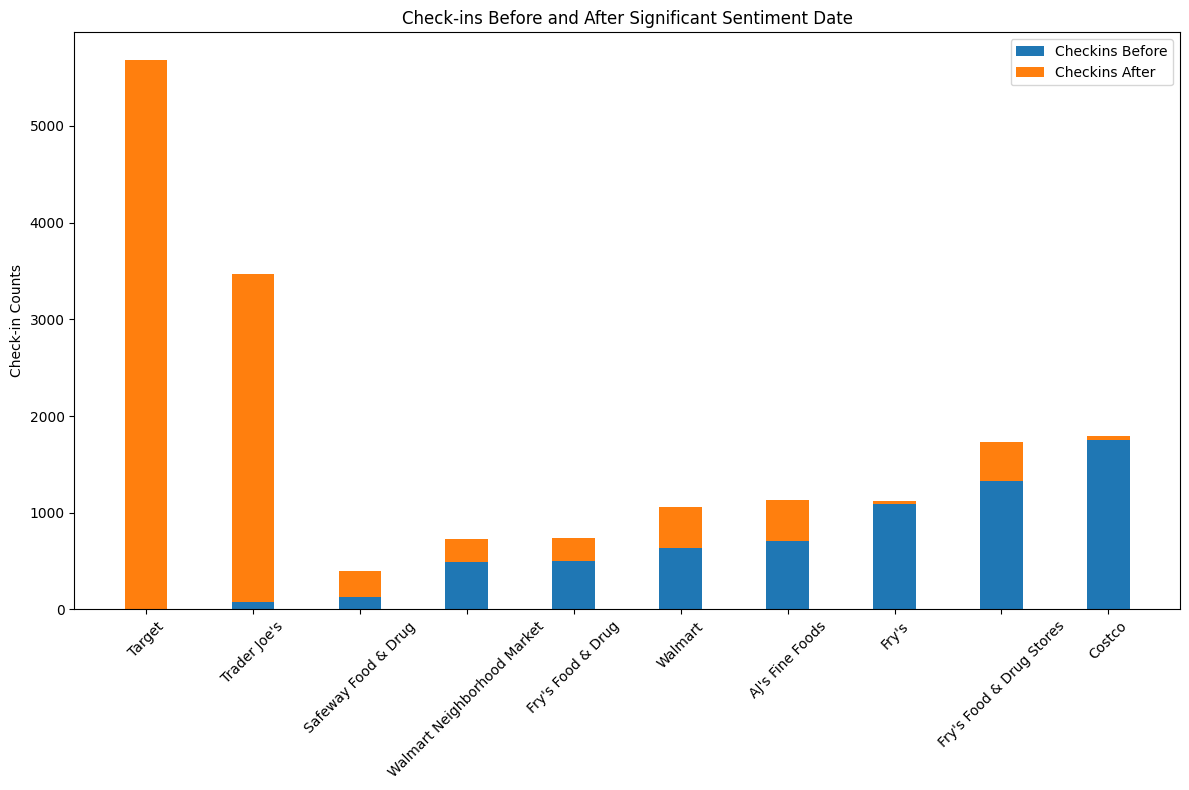

In [39]:
# Example for positive sentiment data
grouped_positive = positive_sentiment_data.groupby('name').apply(lambda x: x.sort_values('useful', ascending=False).head(1)).reset_index(drop=True)

# Repeat for negative sentiment data if needed
#grouped_negative = negative_sentiment_data.groupby('name').apply(lambda x: x.sort_values('useful', ascending=False).head(1)).reset_index(drop=True)

# Initialize a result DataFrame
result_df = pd.DataFrame(columns=['Name', 'Checkins Before', 'Checkins After', 'Sentiment'])

for _, row in grouped_positive.iterrows():
    name = row['name']
    date = pd.to_datetime(row['date'])
    sentiment = row['sentiment']  # Assuming this is how you've structured your sentiment data

    before_count = timestamps_df[(timestamps_df['name'] == name) & (pd.to_datetime(timestamps_df['formatted_date']) < date)].shape[0]
    after_count = timestamps_df[(timestamps_df['name'] == name) & (pd.to_datetime(timestamps_df['formatted_date']) > date)].shape[0]

    result_df = result_df.append({
        'Name': name,
        'Checkins Before': before_count,
        'Checkins After': after_count,
        'Sentiment': sentiment
    }, ignore_index=True)

# Sort the result DataFrame by sentiment and then by check-ins before, for example
result_df.sort_values(by=['Sentiment', 'Checkins Before'], ascending=[False, True], inplace=True)

import matplotlib.pyplot as plt

# Assuming you have fewer businesses or you filter this to a top N for clarity
top_n = result_df.head(10)  # Example: Top 10 businesses

fig, ax = plt.subplots(figsize=(12, 8))

# Create bars for before and after check-ins
ax.bar(top_n['Name'], top_n['Checkins Before'], width=0.4, label='Checkins Before')
ax.bar(top_n['Name'], top_n['Checkins After'], width=0.4, bottom=top_n['Checkins Before'], label='Checkins After')

ax.set_ylabel('Check-in Counts')
ax.set_title('Check-ins Before and After Significant Sentiment Date')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



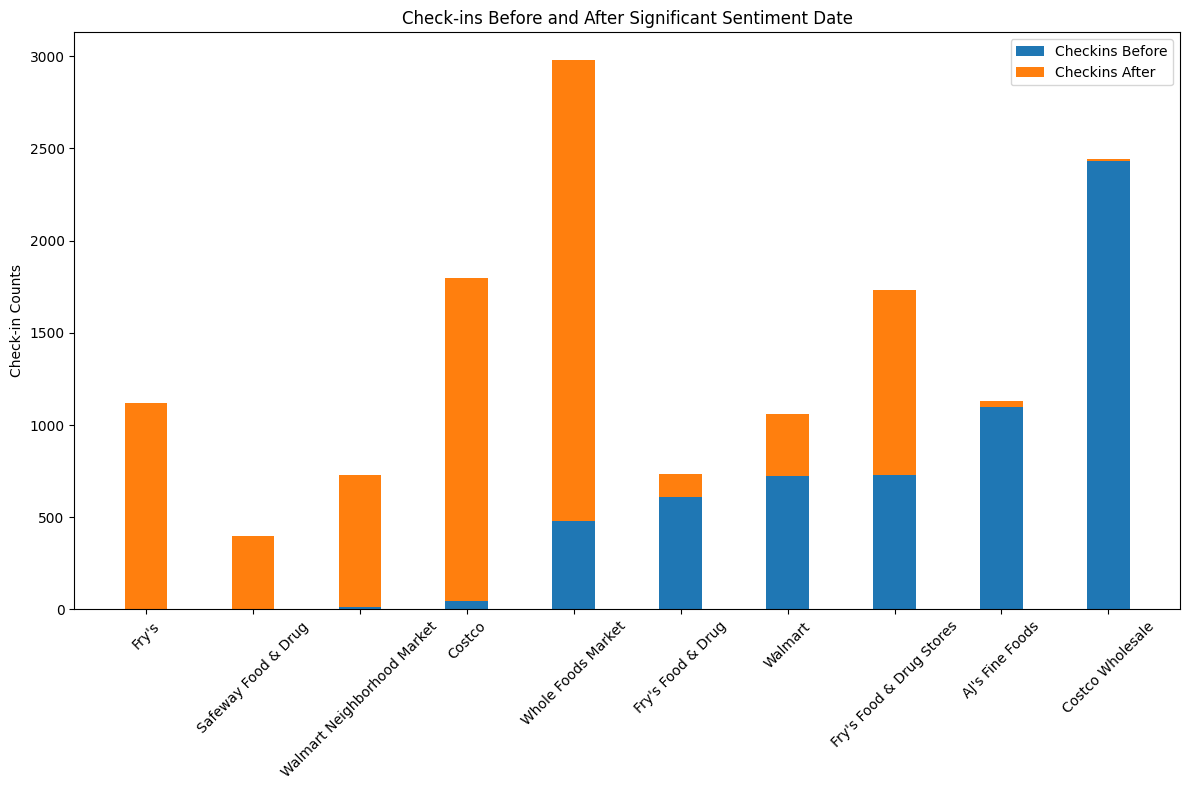

In [40]:
# Repeat for negative sentiment data if needed
grouped_negative = negative_sentiment_data.groupby('name').apply(lambda x: x.sort_values('useful', ascending=False).head(1)).reset_index(drop=True)

# Initialize a result DataFrame
result_df = pd.DataFrame(columns=['Name', 'Checkins Before', 'Checkins After', 'Sentiment'])

for _, row in grouped_negative.iterrows():
    name = row['name']
    date = pd.to_datetime(row['date'])
    sentiment = row['sentiment']  # Assuming this is how you've structured your sentiment data

    before_count = timestamps_df[(timestamps_df['name'] == name) & (pd.to_datetime(timestamps_df['formatted_date']) < date)].shape[0]
    after_count = timestamps_df[(timestamps_df['name'] == name) & (pd.to_datetime(timestamps_df['formatted_date']) > date)].shape[0]

    result_df = result_df.append({
        'Name': name,
        'Checkins Before': before_count,
        'Checkins After': after_count,
        'Sentiment': sentiment
    }, ignore_index=True)

# Sort the result DataFrame by sentiment and then by check-ins before, for example
result_df.sort_values(by=['Sentiment', 'Checkins Before'], ascending=[False, True], inplace=True)

import matplotlib.pyplot as plt

# Assuming you have fewer businesses or you filter this to a top N for clarity
top_n = result_df.head(10)  # Example: Top 10 businesses

fig, ax = plt.subplots(figsize=(12, 8))

# Create bars for before and after check-ins
ax.bar(top_n['Name'], top_n['Checkins Before'], width=0.4, label='Checkins Before')
ax.bar(top_n['Name'], top_n['Checkins After'], width=0.4, bottom=top_n['Checkins Before'], label='Checkins After')

ax.set_ylabel('Check-in Counts')
ax.set_title('Check-ins Before and After Significant Sentiment Date')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

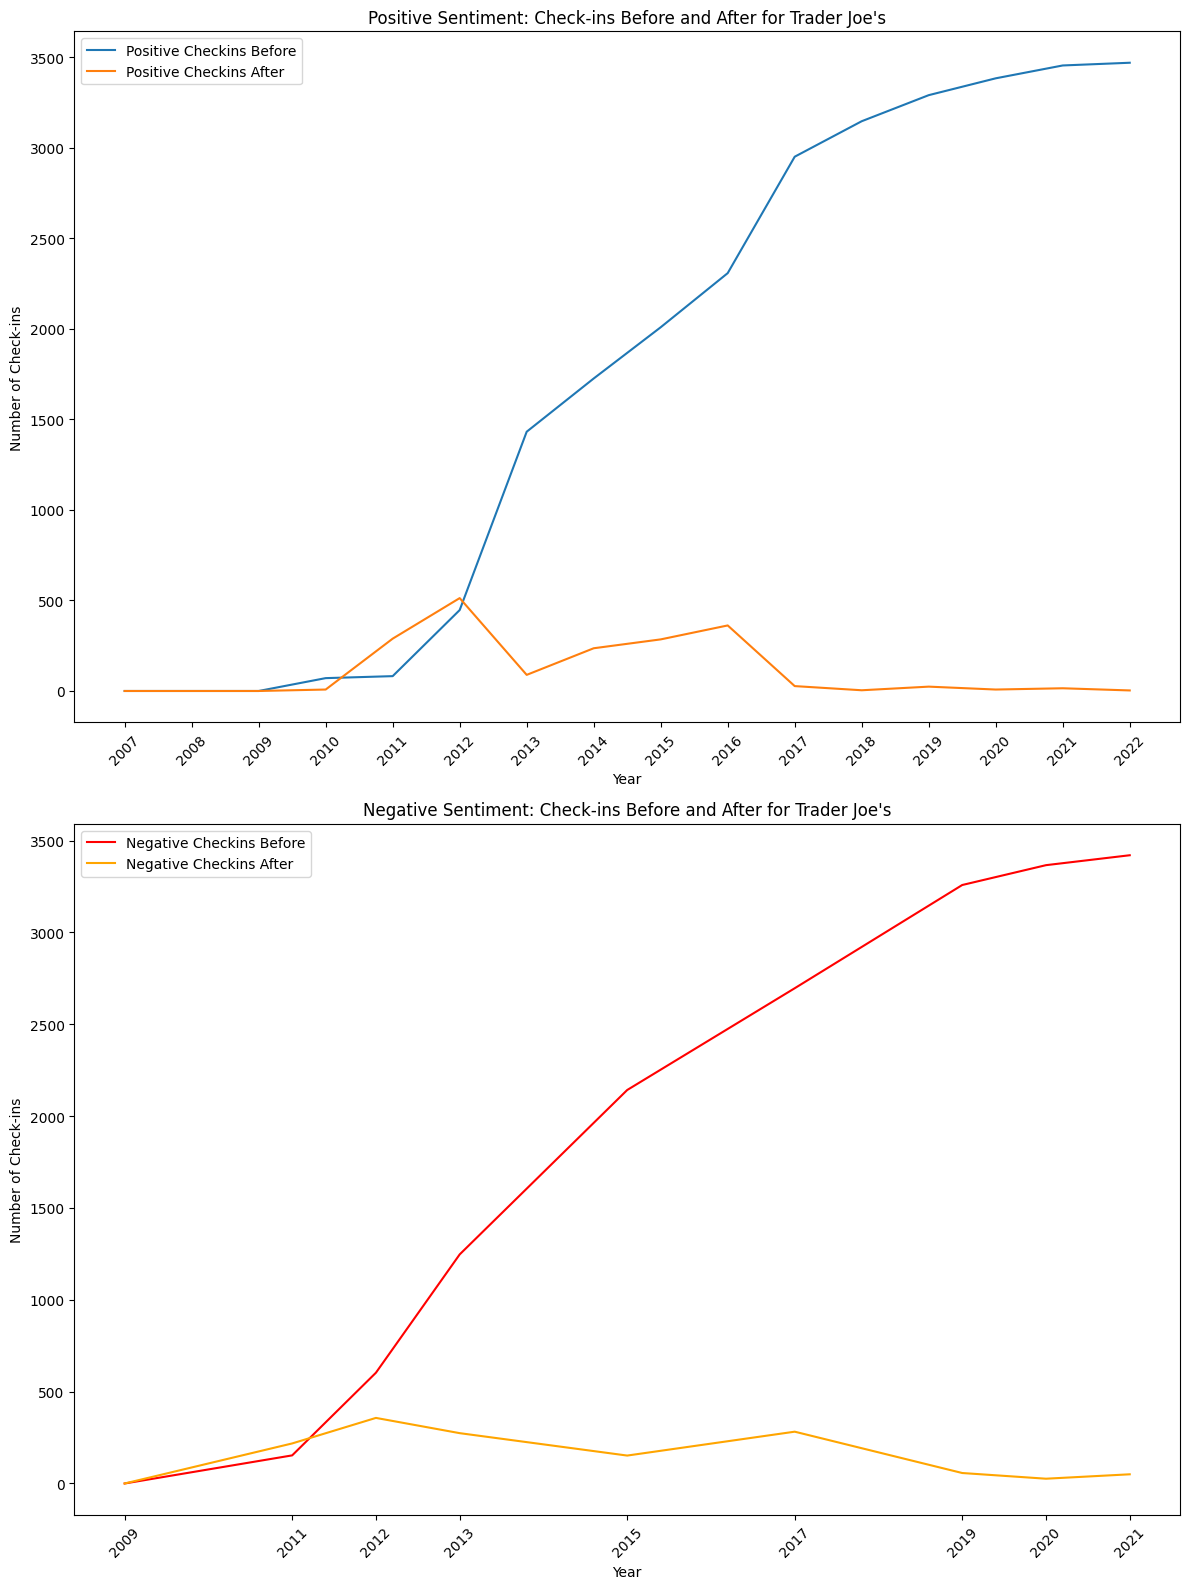

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming positive_sentiment_data and negative_sentiment_data DataFrames, and timestamps_df are already defined

# Specify the supermarket name you want to analyze
selected_supermarket = "Trader Joe's"  # Replace with the supermarket of your choice

# Add a 'year' column to the positive_sentiment_data and negative_sentiment_data DataFrames
positive_sentiment_data['year'] = pd.to_datetime(positive_sentiment_data['date']).dt.year
negative_sentiment_data['year'] = pd.to_datetime(negative_sentiment_data['date']).dt.year

# Filter the positive_sentiment_data and negative_sentiment_data for the selected supermarket
supermarket_positive_data = positive_sentiment_data[positive_sentiment_data['name'] == selected_supermarket]
supermarket_negative_data = negative_sentiment_data[negative_sentiment_data['name'] == selected_supermarket]

# Initialize new DataFrames for the time series analysis
supermarket_positive_time_series = pd.DataFrame()
supermarket_negative_time_series = pd.DataFrame()

# Group by 'year' to get the most useful positive sentiment per year
grouped_by_year_positive = supermarket_positive_data.groupby('year')
grouped_by_year_negative = supermarket_negative_data.groupby('year')

for year, group_positive in grouped_by_year_positive:
    # Get the most useful positive sentiment for the year
    most_useful_positive = group_positive.sort_values('useful', ascending=False).head(1)

    # Assuming the most useful date is the one used for before/after counts
    most_useful_date_positive = pd.to_datetime(most_useful_positive['date'].iloc[0])

    # Count check-ins before and after the most useful positive sentiment date
    before_count_positive = timestamps_df[(timestamps_df['name'] == selected_supermarket) &
                                          (pd.to_datetime(timestamps_df['formatted_date']) < most_useful_date_positive)].shape[0]
    after_count_positive = timestamps_df[(timestamps_df['name'] == selected_supermarket) &
                                         (pd.to_datetime(timestamps_df['formatted_date']) >= most_useful_date_positive) &
                                         (pd.to_datetime(timestamps_df['formatted_date']).dt.year == year)].shape[0]

    supermarket_positive_time_series = supermarket_positive_time_series.append({
        'Year': year,
        'Checkins Before': before_count_positive,
        'Checkins After': after_count_positive,
    }, ignore_index=True)

# Repeat the same process for negative sentiment data
for year, group_negative in grouped_by_year_negative:
    # Get the most useful negative sentiment for the year
    most_useful_negative = group_negative.sort_values('useful', ascending=False).head(1)

    # Assuming the most useful date is the one used for before/after counts
    most_useful_date_negative = pd.to_datetime(most_useful_negative['date'].iloc[0])

    # Count check-ins before and after the most useful negative sentiment date
    before_count_negative = timestamps_df[(timestamps_df['name'] == selected_supermarket) &
                                          (pd.to_datetime(timestamps_df['formatted_date']) < most_useful_date_negative)].shape[0]
    after_count_negative = timestamps_df[(timestamps_df['name'] == selected_supermarket) &
                                         (pd.to_datetime(timestamps_df['formatted_date']) >= most_useful_date_negative) &
                                         (pd.to_datetime(timestamps_df['formatted_date']).dt.year == year)].shape[0]

    supermarket_negative_time_series = supermarket_negative_time_series.append({
        'Year': year,
        'Checkins Before': before_count_negative,
        'Checkins After': after_count_negative,
    }, ignore_index=True)

# Now, you can plot the time series for both positive and negative sentiments for the selected supermarket
fig, ax = plt.subplots(2, 1, figsize=(12, 16))

# Plotting the time series data for positive sentiment
ax[0].plot(supermarket_positive_time_series['Year'], supermarket_positive_time_series['Checkins Before'], label='Positive Checkins Before')
ax[0].plot(supermarket_positive_time_series['Year'], supermarket_positive_time_series['Checkins After'], label='Positive Checkins After')

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Check-ins')
ax[0].set_title(f'Positive Sentiment: Check-ins Before and After for {selected_supermarket}')
ax[0].legend()
ax[0].set_xticks(supermarket_positive_time_series['Year'])
ax[0].set_xticklabels(supermarket_positive_time_series['Year'], rotation=45)

# Plotting the time series data for negative sentiment
ax[1].plot(supermarket_negative_time_series['Year'], supermarket_negative_time_series['Checkins Before'], label='Negative Checkins Before', color='red')
ax[1].plot(supermarket_negative_time_series['Year'], supermarket_negative_time_series['Checkins After'], label='Negative Checkins After', color='orange')

ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of Check-ins')
ax[1].set_title(f'Negative Sentiment: Check-ins Before and After for {selected_supermarket}')
ax[1].legend()
ax[1].set_xticks(supermarket_negative_time_series['Year'])
ax[1].set_xticklabels(supermarket_negative_time_series['Year'], rotation=45)

plt.tight_layout()
plt.show()

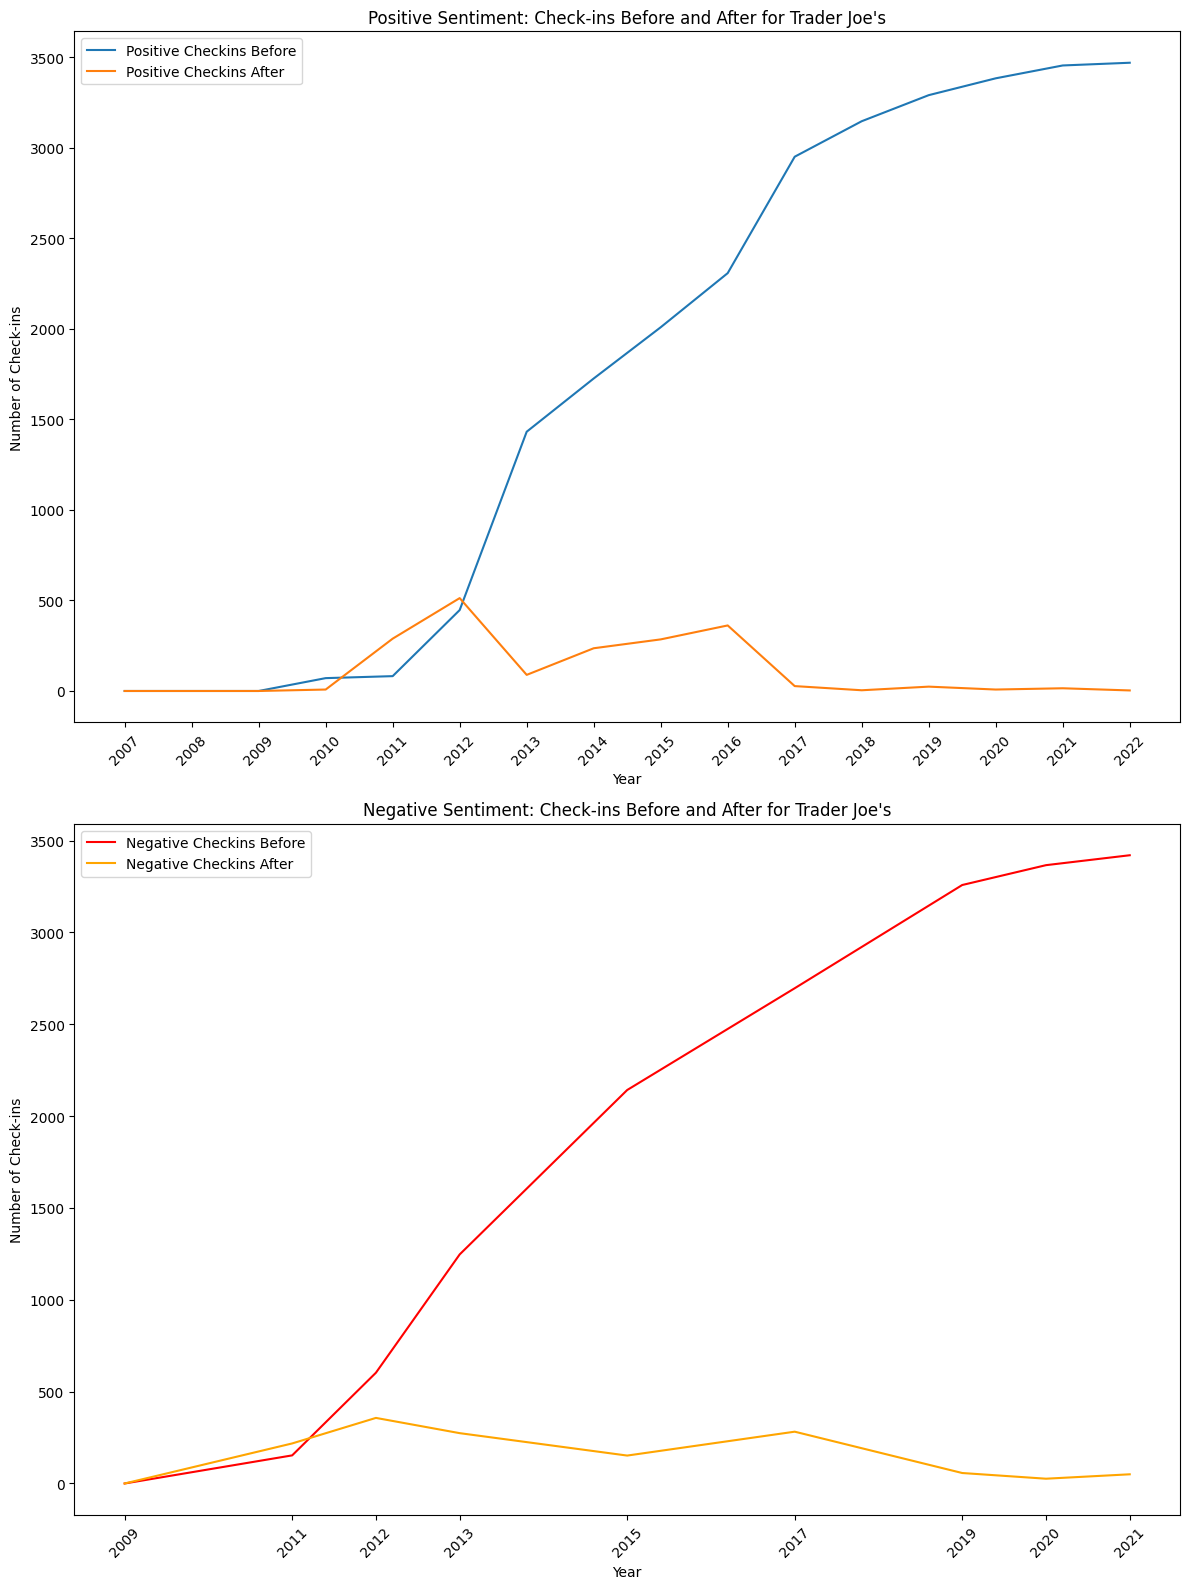

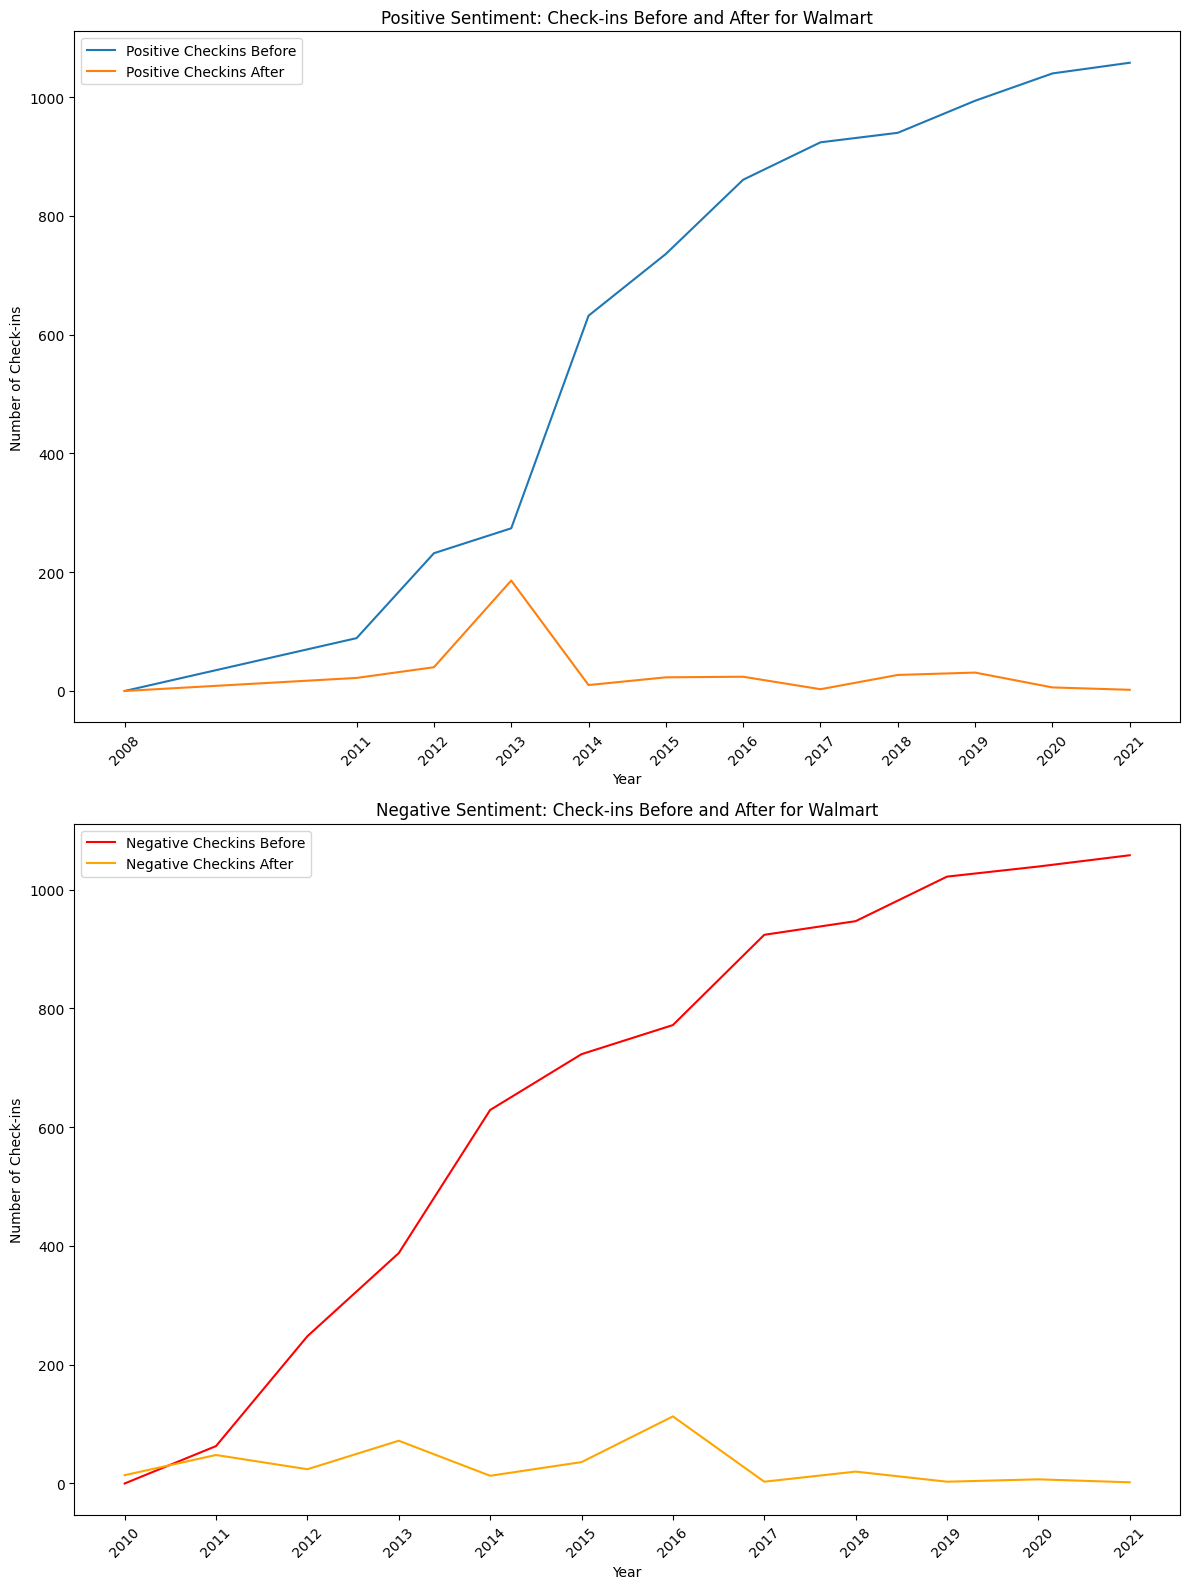

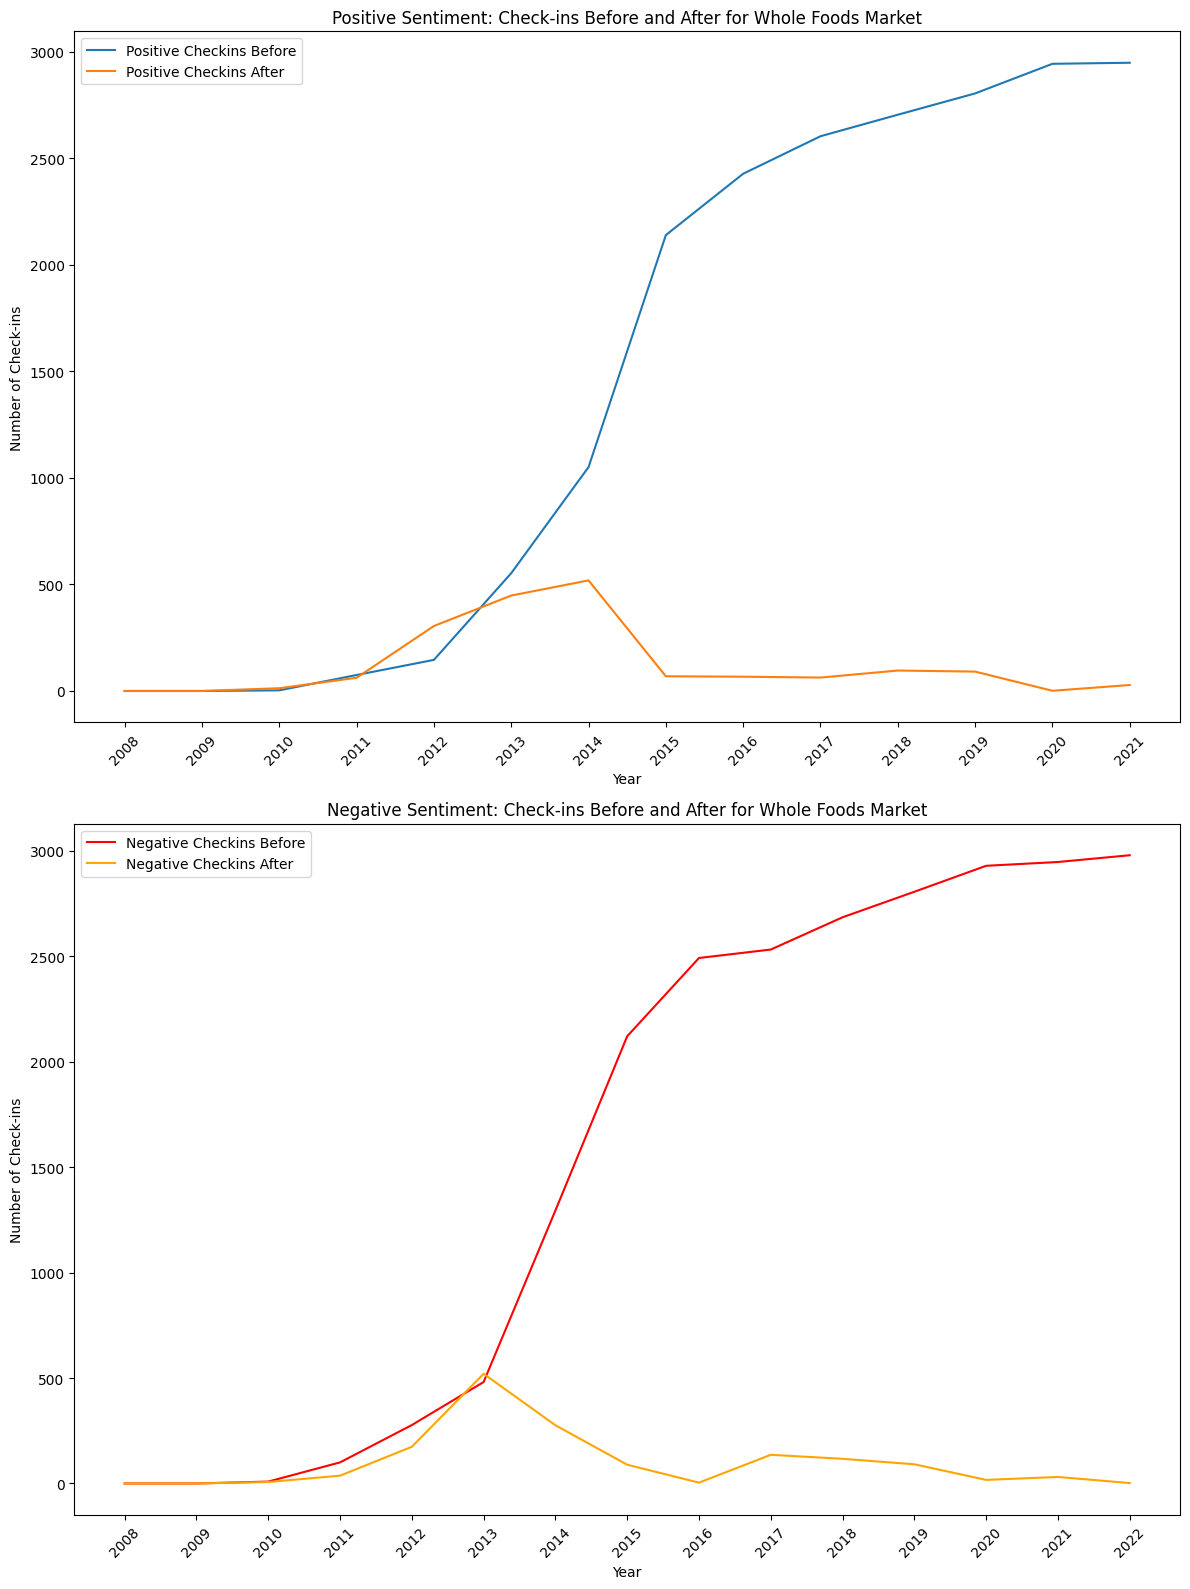

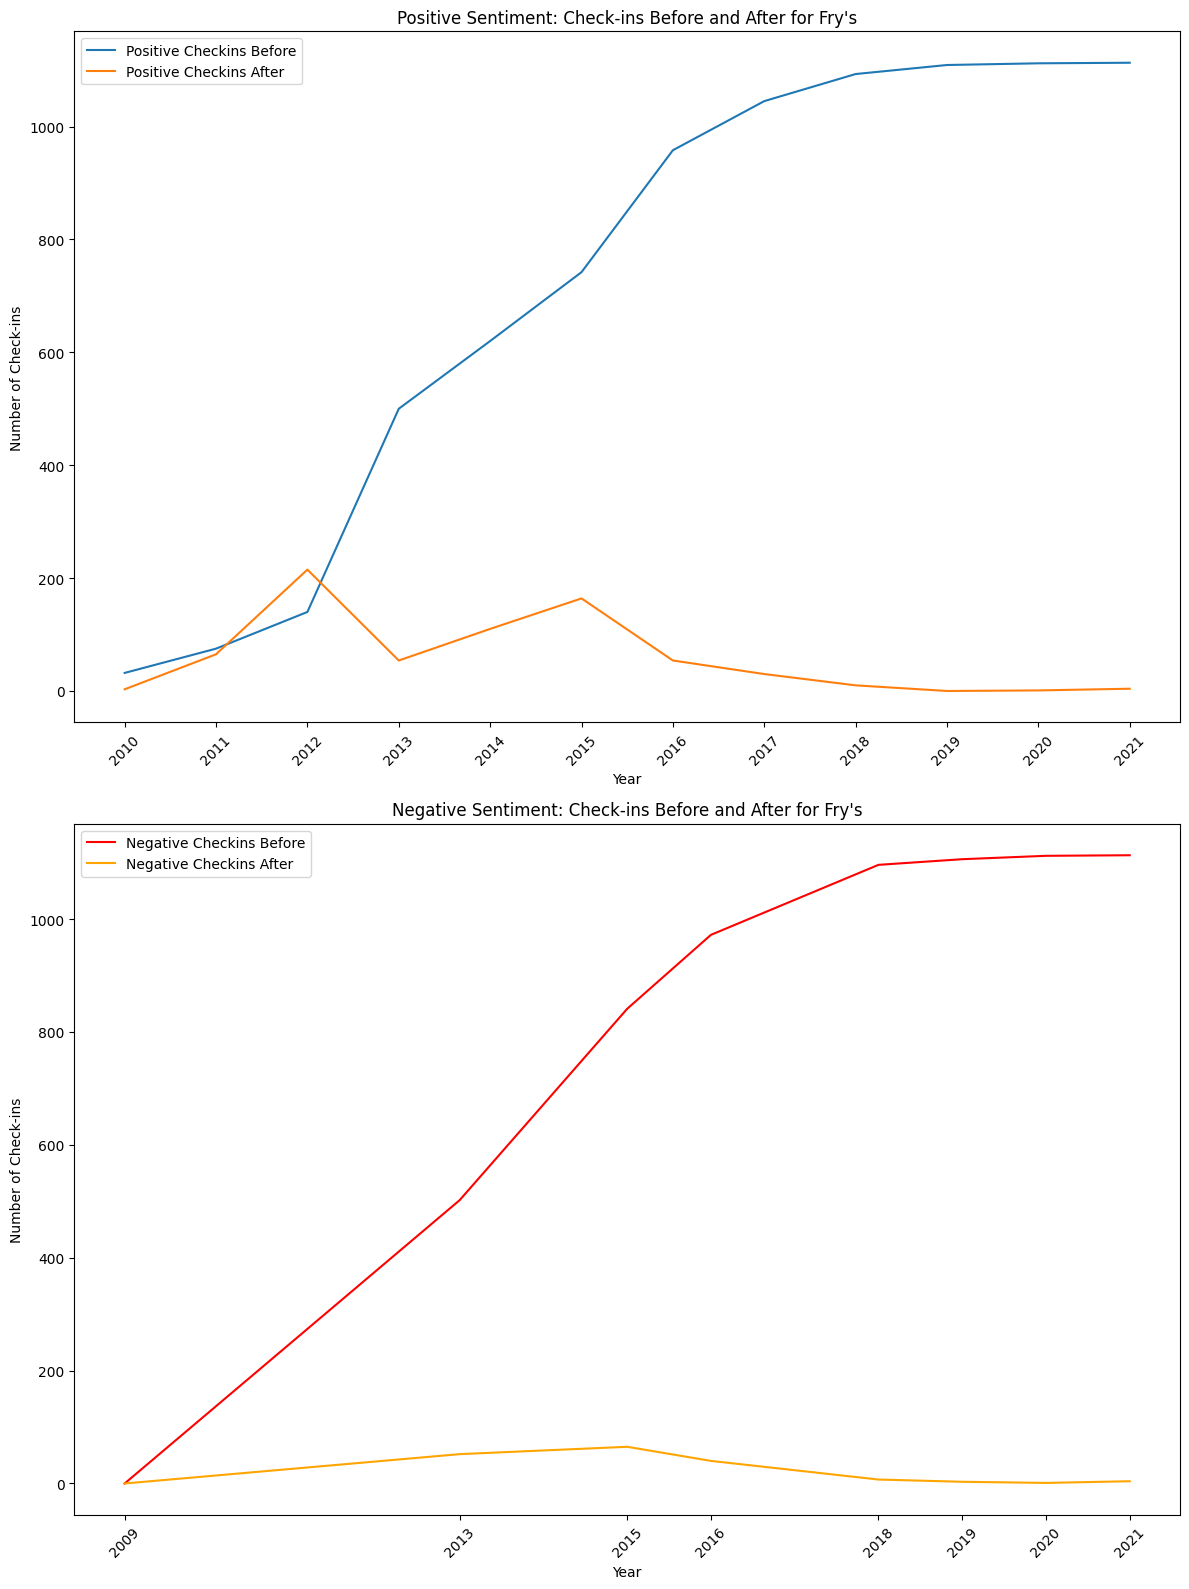

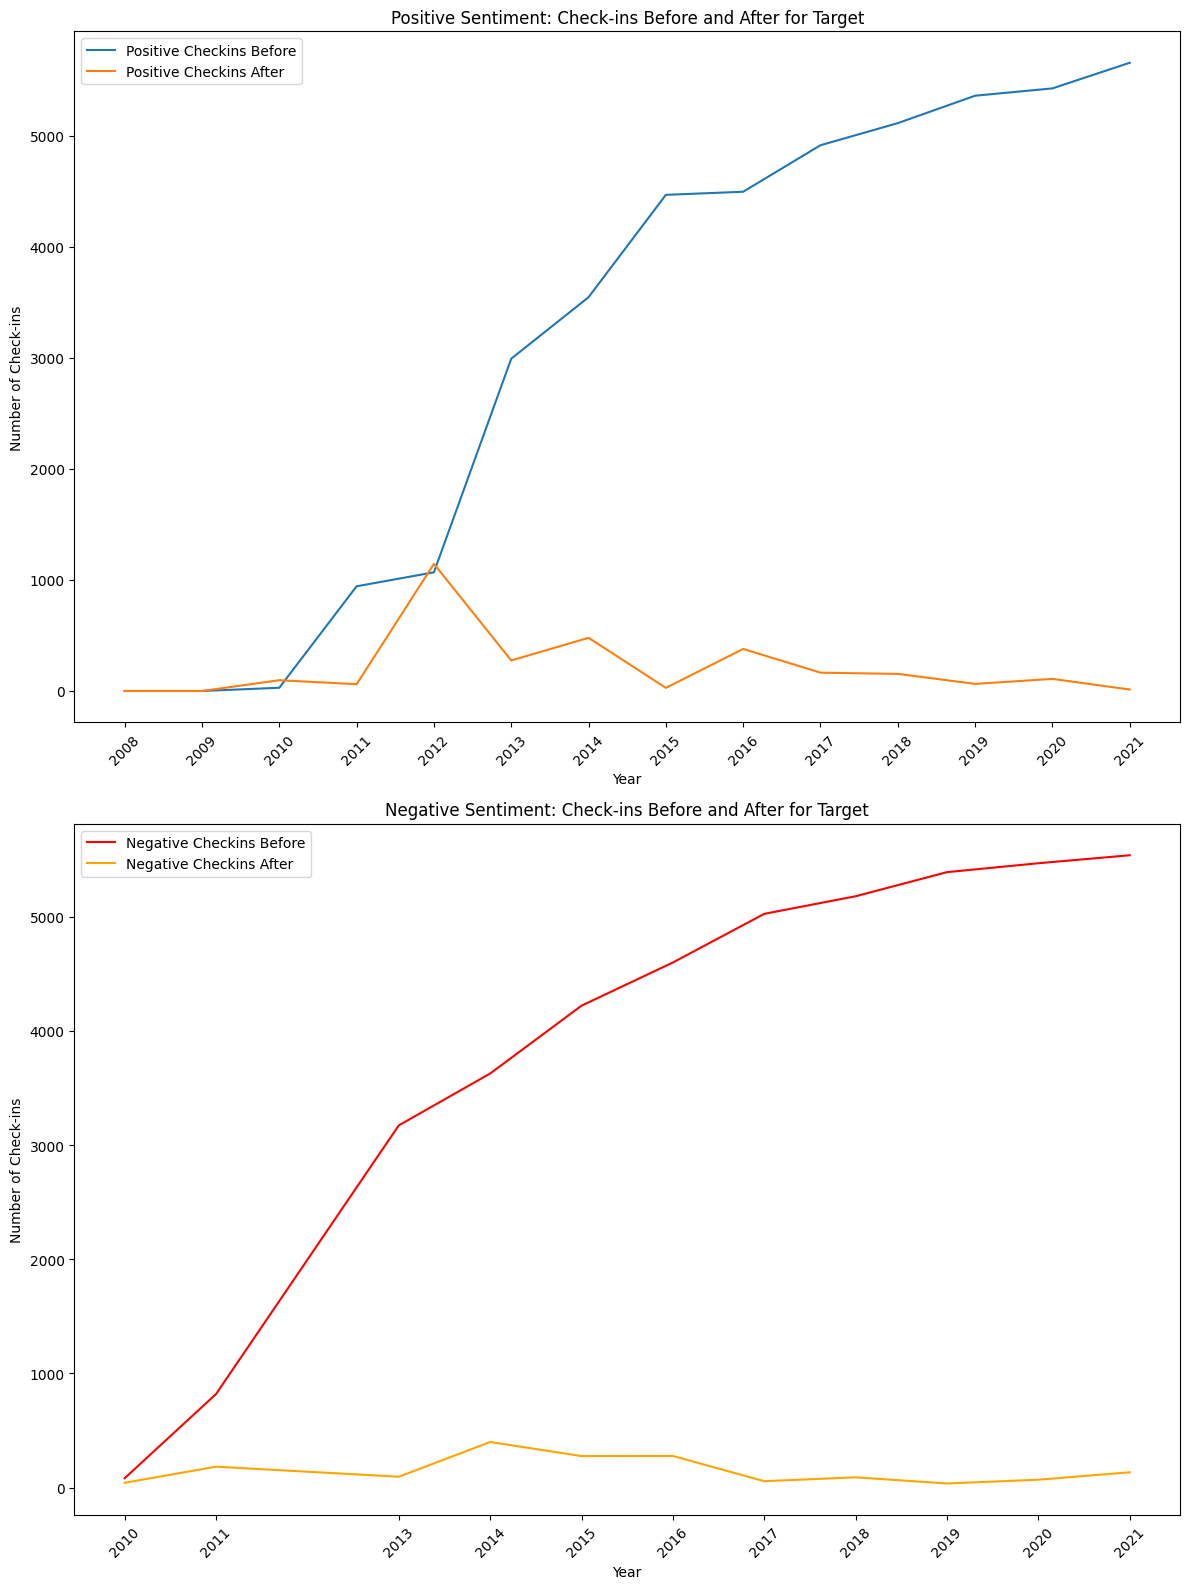

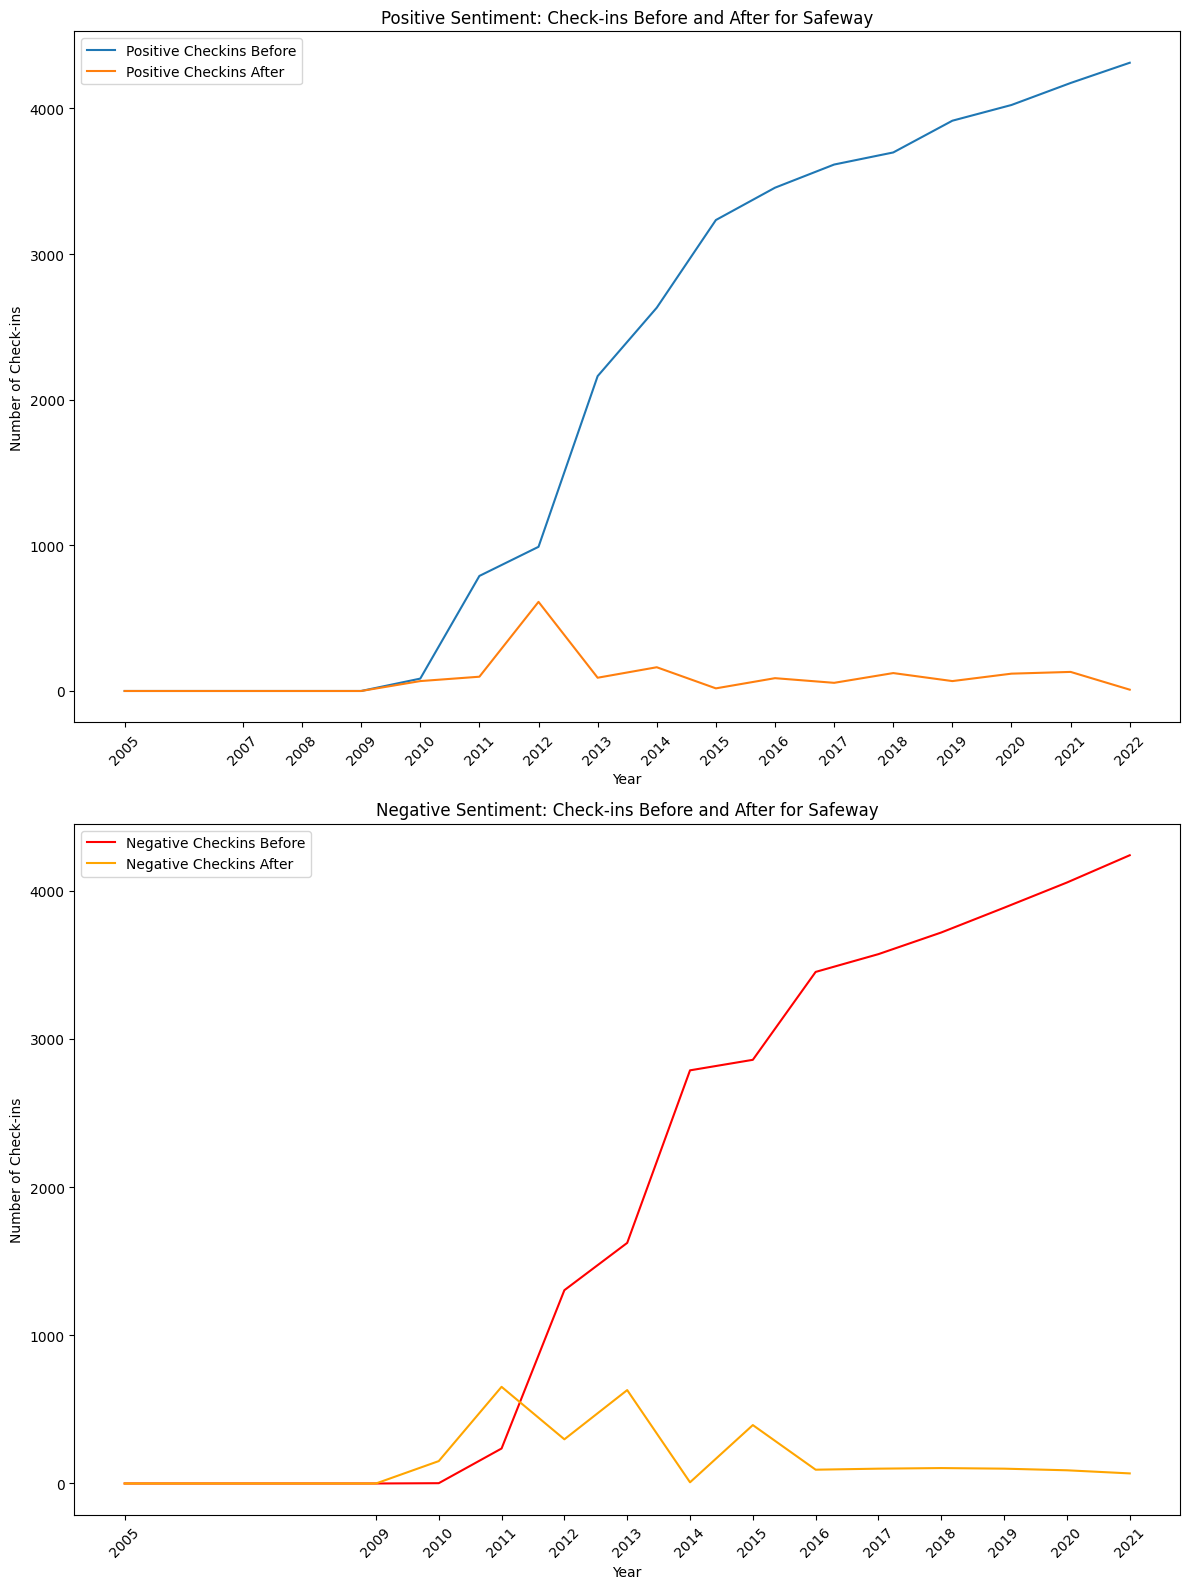

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_supermarkets(supermarket_names, positive_sentiment_data, negative_sentiment_data, timestamps_df):
    for selected_supermarket in supermarket_names:
        # Add a 'year' column to the positive_sentiment_data and negative_sentiment_data DataFrames
        positive_sentiment_data['year'] = pd.to_datetime(positive_sentiment_data['date']).dt.year
        negative_sentiment_data['year'] = pd.to_datetime(negative_sentiment_data['date']).dt.year

        # Filter the positive_sentiment_data and negative_sentiment_data for the selected supermarket
        supermarket_positive_data = positive_sentiment_data[positive_sentiment_data['name'] == selected_supermarket]
        supermarket_negative_data = negative_sentiment_data[negative_sentiment_data['name'] == selected_supermarket]

        # Initialize new DataFrames for the time series analysis
        supermarket_positive_time_series = pd.DataFrame()
        supermarket_negative_time_series = pd.DataFrame()

        # Group by 'year' to get the most useful positive sentiment per year
        grouped_by_year_positive = supermarket_positive_data.groupby('year')
        grouped_by_year_negative = supermarket_negative_data.groupby('year')

        for year, group_positive in grouped_by_year_positive:
            # Get the most useful positive sentiment for the year
            most_useful_positive = group_positive.sort_values('useful', ascending=False).head(1)

            # Assuming the most useful date is the one used for before/after counts
            most_useful_date_positive = pd.to_datetime(most_useful_positive['date'].iloc[0])

            # Count check-ins before and after the most useful positive sentiment date
            before_count_positive = timestamps_df[(timestamps_df['name'] == selected_supermarket) &
                                                  (pd.to_datetime(timestamps_df['formatted_date']) < most_useful_date_positive)].shape[0]
            after_count_positive = timestamps_df[(timestamps_df['name'] == selected_supermarket) &
                                                 (pd.to_datetime(timestamps_df['formatted_date']) >= most_useful_date_positive) &
                                                 (pd.to_datetime(timestamps_df['formatted_date']).dt.year == year)].shape[0]

            supermarket_positive_time_series = supermarket_positive_time_series.append({
                'Year': year,
                'Checkins Before': before_count_positive,
                'Checkins After': after_count_positive,
            }, ignore_index=True)

        # Repeat the same process for negative sentiment data
        for year, group_negative in grouped_by_year_negative:
            # Get the most useful negative sentiment for the year
            most_useful_negative = group_negative.sort_values('useful', ascending=False).head(1)

            # Assuming the most useful date is the one used for before/after counts
            most_useful_date_negative = pd.to_datetime(most_useful_negative['date'].iloc[0])

            # Count check-ins before and after the most useful negative sentiment date
            before_count_negative = timestamps_df[(timestamps_df['name'] == selected_supermarket) &
                                                  (pd.to_datetime(timestamps_df['formatted_date']) < most_useful_date_negative)].shape[0]
            after_count_negative = timestamps_df[(timestamps_df['name'] == selected_supermarket) &
                                                 (pd.to_datetime(timestamps_df['formatted_date']) >= most_useful_date_negative) &
                                                 (pd.to_datetime(timestamps_df['formatted_date']).dt.year == year)].shape[0]

            supermarket_negative_time_series = supermarket_negative_time_series.append({
                'Year': year,
                'Checkins Before': before_count_negative,
                'Checkins After': after_count_negative,
            }, ignore_index=True)

        # Now, you can plot the time series for both positive and negative sentiments for the selected supermarket
        fig, ax = plt.subplots(2, 1, figsize=(12, 16))

        # Plotting the time series data for positive sentiment
        ax[0].plot(supermarket_positive_time_series['Year'], supermarket_positive_time_series['Checkins Before'], label='Positive Checkins Before')
        ax[0].plot(supermarket_positive_time_series['Year'], supermarket_positive_time_series['Checkins After'], label='Positive Checkins After')

        ax[0].set_xlabel('Year')
        ax[0].set_ylabel('Number of Check-ins')
        ax[0].set_title(f'Positive Sentiment: Check-ins Before and After for {selected_supermarket}')
        ax[0].legend()
        ax[0].set_xticks(supermarket_positive_time_series['Year'])
        ax[0].set_xticklabels(supermarket_positive_time_series['Year'], rotation=45)

        # Plotting the time series data for negative sentiment
        ax[1].plot(supermarket_negative_time_series['Year'], supermarket_negative_time_series['Checkins Before'], label='Negative Checkins Before', color='red')
        ax[1].plot(supermarket_negative_time_series['Year'], supermarket_negative_time_series['Checkins After'], label='Negative Checkins After', color='orange')

        ax[1].set_xlabel('Year')
        ax[1].set_ylabel('Number of Check-ins')
        ax[1].set_title(f'Negative Sentiment: Check-ins Before and After for {selected_supermarket}')
        ax[1].legend()
        ax[1].set_xticks(supermarket_negative_time_series['Year'])
        ax[1].set_xticklabels(supermarket_negative_time_series['Year'], rotation=45)

        plt.tight_layout()
        plt.show()

# Example usage:
# List of supermarket names
supermarket_names = ["Trader Joe's", "Walmart", "Whole Foods Market","Fry's","Target","Safeway"]

# Call the function to analyze the supermarkets
analyze_supermarkets(supermarket_names, positive_sentiment_data, negative_sentiment_data, timestamps_df)


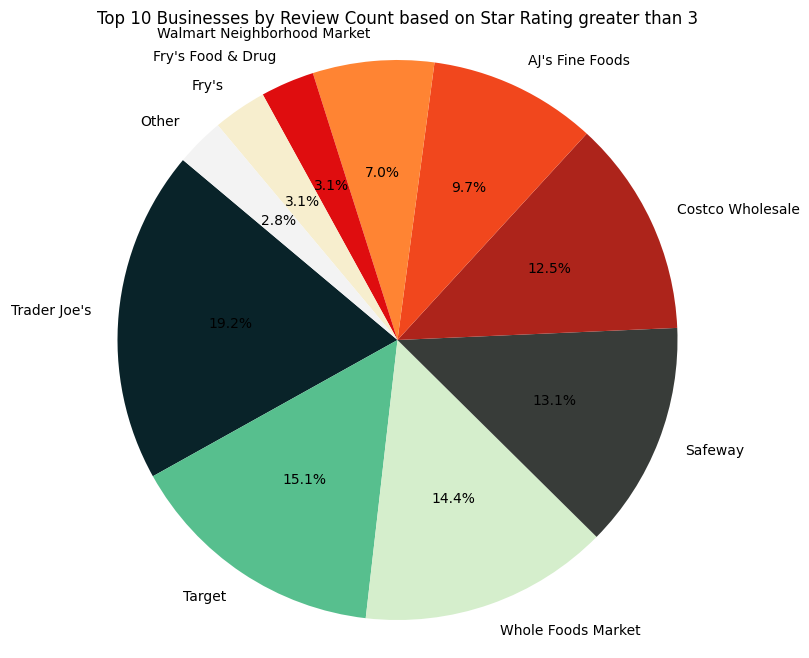

In [42]:
import matplotlib.pyplot as plt

# Data to plot
labels = 'Trader Joe\'s', 'Target', 'Whole Foods Market', 'Safeway', 'Costco Wholesale', \
         'AJ\'s Fine Foods', 'Walmart Neighborhood Market', 'Fry\'s Food & Drug', 'Fry\'s', 'Other'
sizes = [19.2, 15.1, 14.4, 13.1, 12.5, 9.7, 7.0, 3.1, 3.1, 2.8]
colors = ['#092329', '#57bf8e', '#d5eecc', '#383c39', '#ad241b',
          '#f1471d', '#ff8433', '#df0d0f', '#f7eece', '#f3f3f3']

# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

plt.axis('equal')
plt.title('Top 10 Businesses by Review Count based on Star Rating greater than 3')
plt.show()


The suitability of the selected data (reviews, customers, business, regions) for your business questions and other aspects of data evaluation can be assessed as follows:

### Suitability for Business Questions
1. **Reviews**: Reviews provide direct feedback from customers about their experiences, preferences, and pain points. Analyzing reviews can yield insights into customer satisfaction and areas for improvement.
   
2. **Customers**: Data on customers, such as demographics and purchasing behavior, helps in understanding the customer base, tailoring marketing strategies, and identifying key segments for business growth.

3. **Business**: Information about various business aspects, like location, type, and services offered, is crucial for benchmarking performance, identifying competitive advantages, and understanding market positioning.

4. **Regions**: Regional data aids in recognizing geographical patterns, cultural influences, and market trends, which are vital for strategic planning and localization of products and services.

### Sample Size Appropriateness
1. **Adequacy**: The sample size should be large enough to represent the population adequately. A large dataset with reviews, customer profiles, and business information often provides a robust basis for analysis, ensuring the findings are statistically significant.

2. **Generalizability**: If the sample is representative of the broader market or customer base, the findings and predictions made based on the data will be more applicable and reliable.

### Potential Bias in the Data
1. **Selection Bias**: If the data primarily comes from a particular type of customer or region, it may not represent the entire customer base or market.

2. **Response Bias**: Customers who leave reviews might have extreme opinions (either very positive or negative), which may not accurately represent the average customer's experience.

3. **Temporal Bias**: The time frame from which the data is collected can also introduce bias, especially if it does not cover different seasons or business cycles.

### Challenges in Data Processing
1. **Data Quality**: Inconsistent data quality, missing values, or erroneous entries can pose significant challenges in preprocessing.

2. **Unstructured Data**: Reviews are typically unstructured text, requiring advanced NLP techniques for meaningful analysis. This can be resource-intensive and requires expertise in text analytics.

3. **Integration of Diverse Data Sources**: Combining data from different sources (reviews, customer data, business information) may present challenges due to varying formats, scales, or granularity.

4. **Scalability and Efficiency**: Handling large datasets requires efficient data processing and storage solutions, especially when dealing with real-time data analysis or large-scale machine learning tasks.

Understanding these aspects is crucial for effectively leveraging your data to answer business questions, make informed decisions, and strategize effectively.

#Preliminary Data Exploration

Apply topic modeling on the textual data for your project to understand the major topics and briefly comment on the results.

# Proposed Solution

For the project focusing on analyzing supermarket data, particularly reviews and customer interactions, a combination of machine learning and unstructured data analytics methods can be effectively employed. Here’s a detailed outline of the relevant methods and techniques:

### 1. Natural Language Processing (NLP) for Text Analysis:
   - **Text Preprocessing**: Techniques like tokenization, stemming, lemmatization, and stop-word removal to clean and prepare text data.
   - **Sentiment Analysis**: To gauge customer sentiment from reviews using algorithms like VADER or TextBlob, or more complex models like BERT.
   - **Topic Modeling**: Using Latent Dirichlet Allocation (LDA) or Non-Negative Matrix Factorization (NMF) to identify prevalent topics in reviews.

### 2. Time Series Analysis for Trend Detection:
   - **Temporal Data Analysis**: To explore patterns in check-in data or review timestamps.
   - **Seasonality and Trend Analysis**: Using models like ARIMA (AutoRegressive Integrated Moving Average) to understand seasonal trends or forecasting future check-ins.

### Challenges and Considerations:
   - **Data Privacy and Ethical Use**: Ensuring customer data is used ethically and in compliance with privacy laws.
   - **Handling Imbalanced Data**: Implementing techniques to address bias or imbalance in the dataset.
   - **Model Interpretability**: Ensuring the models are interpretable and the results can be explained in business terms.

---

This approach combines various data science techniques to extract meaningful insights from both structured and unstructured data, facilitating informed decision-making and strategic planning.

In [ ]:
!pip install jupyter
!pip install nbconvert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.5 MB/s eta 0:00:00


In [ ]:
!jupyter nbconvert '/content/drive/MyDrive/Colab Notebooks/ProjectEDA_Team414.ipynb' --to html

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/ProjectEDA_Team414.ipynb to html
[NbConvertApp] Writing 1239106 bytes to /content/drive/MyDrive/Colab Notebooks/ProjectEDA_Team414.html
